## Setup libs

In [166]:
import importlib
import brikasutils as bu
importlib.reload(bu)
import shared_utils as utils
from shared_utils import systemMsg, userMsg, assistantMsg
importlib.reload(utils)
import survey
importlib.reload(survey)
import persona
importlib.reload(persona)

import ollama
import numpy as np
from numpy.linalg import norm
import pandas as pd
import os
import re
import time
import json
from typing import List
from openai import OpenAI

# **Analysis**

### Load Simulations

In [167]:
import json
import os
import survey
import pandas as pd
import re
import importlib
import shared_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(utils)
import brikasutils as bu
importlib.reload(bu)

def see_if_column_valid(column_name, df, msg="Verification failed for"):
    dff = df[df[column_name].isna()]
    dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
    print(f"{msg}: {len(dff)} ({len(dfff)} unique)")
    return dfff

MOST_IMPORTANT_COLUMNS = ['sim_signature', 'run_number', "model", "survey_type", "base_sim_signature", "SUBJECT", 'CTX_limit', "retrieval method"]

In [168]:
# Index all simulation files
SIMULATIONS_DIR = "analysis/sims-final-2"

sim_runs = []
for root, dirs, files in os.walk(SIMULATIONS_DIR):
    for file in files:
        if file.split(".")[1] != "json":
            print(f"Invalid file (all must be json) {sim_run['path']}")

        sim_run = {}
        sim_run["SIMULATION_ID"] = file.split(".")[0]
        sim_run["path"] = os.path.join(root, file)
        with open(sim_run["path"], 'r') as f:
            sim = json.load(f)
        sim_run.update(sim["info"]["info"])
        sim_run.update(sim["info"]["settings"])
        sim_runs.append(sim_run)

df = pd.DataFrame(sim_runs)
df = df.dropna(axis=1, how='all')
print(f"Loaded {len(df)} simulation files")

Loaded 234 simulation files


### Infer/Get Needed Values

In [169]:
def infer_survey_type(row):
    if "survey_type" in row and not pd.isna(row["survey_type"]):
        if row["survey_type"] == "KanoSurvey":
            return "KanoSurvey"
        elif row["survey_type"] == "PersonalitySurvey":
            return "PersonalitySurvey"
        else:
            print("Unknown survey type" + row["survey_type"])

    if "prompt_count" in row and not pd.isna(row["prompt_count"]):
        if row["prompt_count"] == 50:
            return "PersonalitySurvey"
        elif row["prompt_count"] == 40:
            return "KanoSurvey"
        else:
            print("Unknown prompt count" + row["prompt_count"])

    return None

df["survey_type"] = df.apply(infer_survey_type, axis=1) 
df["survey_type"].value_counts()

# extract_run_number
def extract_run_number(sim_id):
    try:
        parts = sim_id.rsplit('_', 1)  # Attempt to split by the last underscore
        if len(parts) == 2:  # Check if the split was successful
            return pd.Series([parts[0], int(parts[-1])])
        else:
            print(f"Error while processing {sim_id}")
            return pd.Series([pd.NA, pd.NA])  # Return None for last_number if split fails
         
    except Exception as e:  # Generic exception handling
        print(f"Error while processing {sim_id}")
        return pd.Series([pd.NA, pd.NA])

df[['sim_signature', 'run_number']] = df['SIMULATION_ID'].apply(extract_run_number)

In [170]:
# infer_if_simulation_is_base
def infer_if_simulation_is_base(row):
    if row["sim_signature"][:4] == "base":
        return True
    return False
    
df["is_base"] = df.apply(infer_if_simulation_is_base, axis=1)

# Below: Vanity Print
dff = df[df["is_base"] == True]
dff = dff.sort_values(by=['sim_signature', 'run_number'])
dff = dff.dropna(axis=1, how='all')
dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
print(f"Found {len(dff)} ({len(dfff)} unique) base simulations")

Found 18 (6 unique) base simulations


In [171]:
# Map simulations to their base
def map_simulation_to_base(row):
    if row["is_base"] == True:
        return "(base)"
    if row["survey_type"] == "KanoSurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_kano_v2_gpt35"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_personality_v2_gpt35"

    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3-70b":
        return "base-kano-29_llama3-70b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3-70b":
        return "base-pers-29_llama3-70b_V7"
    
    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3-8b":
        return "base-kano-29_llama3-8b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3-8b":
        return "base-pers-29_llama3-8b_V7"
    
    if row["survey_type"] == "KanoSurvey" and row["model"] == "mixtral-8x22b":
        return "base-kano-29_mixtral-8x22b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "mixtral-8x22b":
        return "base-pers-29_mixtral-8x22b_V7"
    
    return pd.NA
    
df["base_sim_signature"] = df.apply(map_simulation_to_base, axis=1)
dff = see_if_column_valid("base_sim_signature", df, "Missing mappings")
if len(dff) == 0:
    print("All mappings are valid")
else:
    print("Not all mappings are valid. See the missing mappings below")
    display(dff)

def infer_subject(row):
    if row["is_base"]:
        return "(base)"
    if "SUBJECT" in row and pd.notna(row["SUBJECT"]):
        if row["SUBJECT"] == "airidas" or row["SUBJECT"] == "Airidas" or row["SUBJECT"] == "airi":
            return "airidas"
        if row["SUBJECT"] == "elias" or row["SUBJECT"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['SUBJECT']}")
        return pd.NA
    if "subject" in row and pd.notna(row["subject"]):
        if row["subject"] == "airidas" or row["subject"] == "Airidas" or row["subject"] == "airi":
            return "airidas"
        if row["subject"] == "elias" or row["subject"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['subject']}")
        return pd.NA
    if row["sim_signature"][:4] == "airi":
        return "airidas"
    if row["sim_signature"][:3] == "eli":
        return "elias"
    return pd.NA

df["SUBJECT"] = df.apply(infer_subject, axis=1)
dff = see_if_column_valid("SUBJECT", df, "Missing subjects")
if len(dff) == 0:
    print("All subjects are valid")
else:
    display(dff)

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)


Missing mappings: 0 (0 unique)
All mappings are valid
Missing subjects: 0 (0 unique)
All subjects are valid


### Compute Scores

#### Setup

In [172]:
def get_surv_from_info(row):
    if row["survey_type"] == "KanoSurvey":
        return survey.KanoSurvey()
    elif row["survey_type"] == "PersonalitySurvey":
        return survey.PersonalitySurvey()
    else:
        raise Exception("Unknown survey type: " + row["survey_type"])

all_possible_asnwers = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]
def extract_possible_answer(value):
    for phrase in all_possible_asnwers:
        pattern = r'(?i)' + re.escape(phrase)
        match = re.search(pattern, value)
        if match:
            # if value != phrase:
            #     er.append([value, phrase])  
            return match.group()
    return value  # Return the original value if no possible answer is found

############ Invalid Answers ##################
def get_invalid_answers(value):
    if pd.isna(value):
        return ""
    elif value == "NaN":
        return ""
    elif value in all_possible_asnwers:
        return ""
    else:
        return value

def clean_simulation_QA(df) -> pd.DataFrame:
    df['answer'] = df['answer'].apply(lambda x: x.strip())
    for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
        df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))
    df['answer'] = df['answer'].str.upper()
    df['answer'] = df['answer'].apply(extract_possible_answer)

    REMAP_MISSING_E = {"AGRE": "AGREE", "SOMEWHAT AGRE": "SOMEWHAT AGREE", "SOMEWHAT DISAGRE": "SOMEWHAT DISAGREE", "DISAGRE": "DISAGREE", "I DON'T LIKE IT": "I DISLIKE IT"}
    df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: REMAP_MISSING_E.get(x, x))

    PARTIAL_MATCH_REMAP = {"SOMEWHAT AG":"SOMEWHAT AGREE" }
    df["answer"] = df["answer"].apply(
        lambda answer: next((value for key, value in PARTIAL_MATCH_REMAP.items() if key in answer), answer)
    )

    # Update isValid
    df['isValid'] = df['answer'].apply(lambda x: x in all_possible_asnwers)

    # if all values in isValid is true, drop the column, else print a message
    if not df['isValid'].all():
        print("Warning, some answers were not valid. See df['isValid']")      

    return df

# Proces simulation output
def add_airidas_and_elias_answers(df, surv) -> pd.DataFrame:
    # Add airidas and elias answers
    air = surv.test_answers["airidas"]
    eli = surv.test_answers["elias"]

    # Sanity Check
    if len(air) != len(df):
        raise Exception(f"Survey and DF length mismatch {len(air)} != {len(df)}. Suvey type: {str(type(surv))}")

    df.insert(2, "airidas", air[:len(df)])
    df.insert(3, "elias", eli[:len(df)])

    # Convert to uppercase
    if isinstance(surv, survey.KanoSurvey):
        df['answer'] = df['answer'].str.upper()
        df['airidas'] = df['airidas'].str.upper()
        df['elias'] = df['elias'].str.upper()
        
    return df

def remap_answers_to_integers(df, surv, remap_answer = True):
    if isinstance(surv, survey.KanoSurvey):
        remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
        if remap_answer:
            df['answer'] = df['answer'].str.upper()
            df['answer'] = df['answer'].map(remap_dict)
        df['airidas'] = df['airidas'].str.upper()
        df['elias'] = df['elias'].str.upper()
        
        df['airidas'] = df['airidas'].map(remap_dict)
        df['elias'] = df['elias'].map(remap_dict)
    elif isinstance(surv, survey.PersonalitySurvey):
        remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
        if remap_answer:
            df['answer'] = df['answer'].map(remap_dict)

    return df

def evaluate_single_simulation_run(df, sim_row) -> dict:
    # compute the percentage of correct answers and average loss (MAE)
    p_corr_airidas = df['answer'].corr(df['airidas'])
    p_corr_elias = df['answer'].corr(df['elias'])
    mae_airi = (df['answer'] - df['airidas']).abs().sum() / len(df)
    mae_eli = (df['answer'] - df['elias']).abs().sum() / len(df)

    if sim_row["is_base"]: mae, p_corr = pd.NA, pd.NA
    elif sim_row["SUBJECT"] == "airidas": mae, p_corr = mae_airi, p_corr_airidas
    elif sim_row["SUBJECT"] == "elias": mae, p_corr = mae_eli, p_corr_elias
    else: raise Exception("Unknown subject")

    result_data = {
        "MAE": mae,
        "MAE_airi": mae_airi,
        "MAE_eli": mae_eli,
        "p-corr": p_corr,
        "p-corr_Airidas": p_corr_airidas,
        "p-corr_Elias": p_corr_elias,
        "question_count": len(df),
    }
    return result_data



ADD_TO_MOST_IMPORTANT_COLUMNS = ["MAE_airi", "MAE_eli"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col not in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.append(col)  

#### Compute Scores - Exec

In [173]:
EVALUATE_INVALID_SIMULATIONS = True
# If one of the questions in a simulation was answered with an invalid asnwer,
#   should the whole sim still be used while dropping the questions with invalid answers?

invalid_vals = []
tmp = []

for index, sim_row in df.iterrows():
    sim = utils.load_sim(sim_row["path"])
    dfQA = utils.dataframe_from_QA(sim["QA"])
    with bu.MutePrint():
        surv = get_surv_from_info(sim_row)
        dfQA = clean_simulation_QA(dfQA)
    dfQA = add_airidas_and_elias_answers(dfQA, surv)

    ## Check for invalid values
    if not dfQA['isValid'].all():
        invalid_vals.extend(dfQA.loc[~dfQA['isValid'], 'answer'].tolist())
        
        if EVALUATE_INVALID_SIMULATIONS:
            print(f"{sim_row['SIMULATION_ID']} has invalid value(s). Sim will be included with dropped rows.")
            dfQA = dfQA[dfQA['isValid'] == True]
        else:
            print(f"Skipping {sim_row['SIMULATION_ID']} due to invalid answers")
            continue

    dfQA = remap_answers_to_integers(dfQA, surv)
    for key, value_name in evaluate_single_simulation_run(dfQA, sim_row = sim_row).items():
        df.at[index, key] = round(value_name, 3) if not pd.isna(value_name) else value_name

# Rename values
df['CTX_limit'] = df['CTX_limit'].astype(str)
df.loc[df['CTX_limit'] == "0", 'CTX_limit'] = '1-chunk'

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)

if len(invalid_vals) > 0:
    print(f"{len(invalid_vals)} Invalid values:")
    display(pd.DataFrame(invalid_vals, columns=["Invalid Values"]))
    if EVALUATE_INVALID_SIMULATIONS:
        print("EVALUATE_INVALID_SIMULATIONS == True. All invalid values were dropped")
else:
    print("All values are valid")

airidas-pers-4000_mixtral-8x22b_V7_2 has invalid value(s). Sim will be included with dropped rows.
airidas-pers-7500_mixtral-8x22b_V7_0 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_0 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_1 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_2 has invalid value(s). Sim will be included with dropped rows.
5 Invalid values:


,Invalid Values
0,IT SEEMS THAT YOU HAVE A TEXT-BASED CONVERSATI...
1,IT SEEMS LIKE YOU ARE PROVIDING A SERIES OF ME...
2,THE CONVERSATION IS BETWEEN TWO FRIENDS DISCUS...
3,IT SEEMS LIKE YOU ARE LOOKING FOR A WAY TO CON...
4,IT SEEMS LIKE YOU AND YOUR FRIEND ARE DISCUSSI...


EVALUATE_INVALID_SIMULATIONS == True. All invalid values were dropped


### Vizuolisation Setup: Common 
Established some common features that may be used throughout the whole document.
It need to be runs before the main viz, because its needed for Ditribution vizualisations.

In [174]:
import textwrap
def getGlobalColorByParam(param):
    if param == 'SUBJECT':
        color = 'lightblue'
    elif param == 'survey_type':
        color = 'lightblue'
    elif param == 'model':
        color = 'lightgreen'
    else:
        color = 'salmon'
    return color

def super_format_ax(ax, custom_x_label_size=13):
    tick_locations = ax.get_xticks()
    # Retrieve and wrap the existing labels
    tick_labels = [textwrap.fill(label.get_text(), width=8, break_long_words=True, break_on_hyphens=True) 
                for label in ax.get_xticklabels()]
    ax.set_xticks(tick_locations) 
    ax.set_xticklabels(tick_labels, fontsize=custom_x_label_size, fontweight="semibold", rotation=0)

    tick_locations_y = ax.get_yticks()
    # Retrieve and wrap the existing labels
    tick_labels_y = [textwrap.fill(label.get_text(), width=8, break_long_words=True, break_on_hyphens=True) 
                for label in ax.get_yticklabels()]
    ax.set_yticks(tick_locations_y) 
    ax.set_yticklabels(tick_labels_y, fontsize=12,rotation=0, color='#808080')
    ax.set_facecolor('#f5f5f5')

def add_value_texts(grouped_data, ax):
    mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
    pos = range(len(mins))  # Positions of the boxplots
    vertical_offset = 0.017  # offset each text to avoid clutter
    COLOR = '#606060'
    for tick in pos:
        ax.text(tick, mins[tick] - vertical_offset - 0.022, f'{mins[tick]:.2f}', horizontalalignment='center', size='10', color=COLOR) #TODO
        ax.text(tick, medians[tick] + vertical_offset - 0.003, f'{medians[tick]:.2f}', horizontalalignment='center', size='11.5', color=COLOR) #TODO
        ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='10', color=COLOR) #TODO

### Vizualisation Distribution

Using default Kano Survey CSV file: surveys/survey_kano-model.csv
Using default Personality Survey CSV file: surveys/survey_personality-test.csv


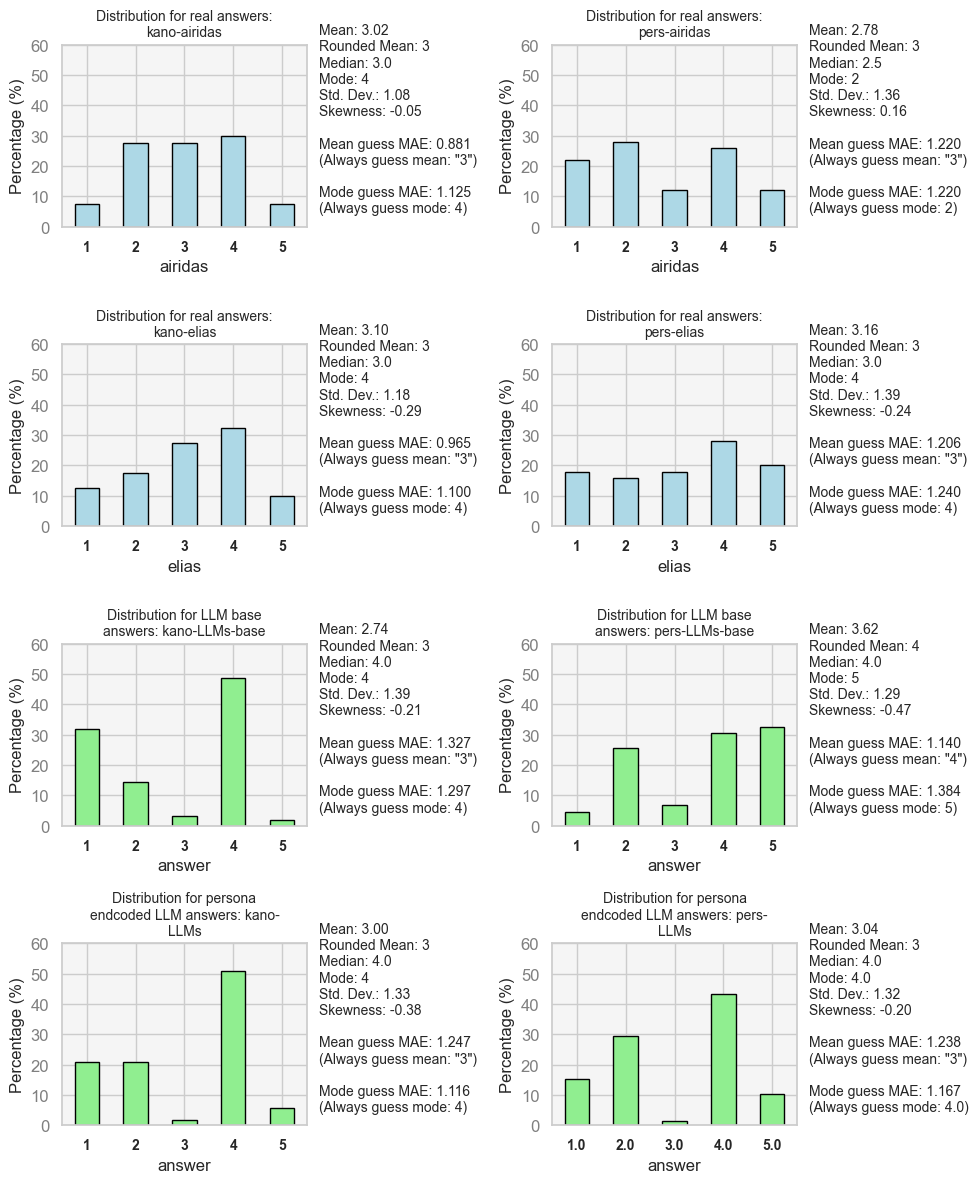

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

import matplotlib.pyplot as plt
dfQAs_kano = []
dfQAs_pers = []
dfQAs_pers_base = []
dfQAs_kano_base = []
for index, sim_row in df.iterrows():
    sim = utils.load_sim(sim_row["path"])
    dfQA = utils.dataframe_from_QA(sim["QA"])
    with bu.MutePrint():
        surv = get_surv_from_info(sim_row)
        dfQA = clean_simulation_QA(dfQA)
    dfQA = add_airidas_and_elias_answers(dfQA, surv)
    dfQA = remap_answers_to_integers(dfQA, surv)

    if sim_row["is_base"]:
        if sim_row["survey_type"] == "KanoSurvey":
            dfQAs_kano_base.append(dfQA)
        elif sim_row["survey_type"] == "PersonalitySurvey":
            dfQAs_pers_base.append(dfQA)
    else:
        if sim_row["survey_type"] == "KanoSurvey":
            dfQAs_kano.append(dfQA)
        elif sim_row["survey_type"] == "PersonalitySurvey":
            dfQAs_pers.append(dfQA)


surv_kano = survey.KanoSurvey()
surv_pers = survey.PersonalitySurvey()
surv_kano.df = remap_answers_to_integers(surv_kano.df, surv_kano, remap_answer=False)
surv_pers.df = remap_answers_to_integers(surv_pers.df, surv_pers, remap_answer=False)

#########################################################
#########################################################

# Assuming the dataframes and lists of dataframes are defined and imported already
val_counts_raw = {
    "kano-airidas": {
        "data": surv_kano.df['airidas'].value_counts().sort_index(),
        "text": "real answers",
        "color": "lightblue",
        },
    "pers-airidas": {
        "data": surv_pers.df['airidas'].value_counts().sort_index(),
        "text": "real answers",
        "color": "lightblue",
        },
    "kano-elias": {
        "data": surv_kano.df['elias'].value_counts().sort_index(),
        "text": "real answers",
        "color": "lightblue",
        },
    "pers-elias": {
        "data": surv_pers.df['elias'].value_counts().sort_index(),
        "text": "real answers",
        "color": "lightblue",
        },
    'kano-LLMs-base': {
        "data": pd.concat([df['answer'] for df in dfQAs_kano_base]).value_counts().sort_index(),
        "text": "LLM base answers",
        "color": "lightgreen",
        },
    "pers-LLMs-base": {
        "data": pd.concat([df['answer'] for df in dfQAs_pers_base]).value_counts().sort_index(),
        "text": "LLM base answers",
        "color": "lightgreen",
        },
    'kano-LLMs': {
        "data": pd.concat([df['answer'] for df in dfQAs_kano]).value_counts().sort_index(),
        "text": "persona endcoded LLM answers",
        "color": "lightgreen",
        },
    "pers-LLMs": {
        "data": pd.concat([df['answer'] for df in dfQAs_pers]).value_counts().sort_index(),
        "text": "persona endcoded LLM answers",
        "color": "lightgreen",
        },
    
}

plt.figure(figsize=(10, 12))
for i, (key, value_name) in enumerate(val_counts_raw.items(), start=1):
    info = value_name.copy()
    ax = plt.subplot(4, 2, i)
    title_text = f"Distribution for {value_name['text']}: {key}"
    wrapped_title = textwrap.fill(title_text, width=30)  # You can adjust width as needed
    plt.title(wrapped_title, fontsize=10)
    plt.xlabel('Answer Values')
    plt.ylabel('Percentage (%)')

    value_name = value_name["data"]
    # Calculating statistics on the original unnormalized counts
    val_array = np.repeat(value_name.index, value_name.values)
    mean = np.mean(val_array)
    median = np.median(val_array)
    mode = value_name.idxmax()
    std_dev = np.std(val_array)
    skewness = np.sum((val_array - mean)**3) / (len(val_array) * std_dev**3)
    mae = np.mean(np.abs(val_array - mean))
    mae_mode = np.mean(np.abs(val_array - mode))

    stats_text = (
        f'Mean: {mean:.2f}\n'
        f"Rounded Mean: {round(mean)}\n"
        f'Median: {median}\n'
        f'Mode: {mode}\n'
        f'Std. Dev.: {std_dev:.2f}\n'
        f'Skewness: {skewness:.2f}\n\n'
        f'Mean guess MAE: {mae:.3f}\n'
        f'(Always guess mean: "{round(mean)}")\n\n'
        f'Mode guess MAE: {mae_mode:.3f}\n'
        f'(Always guess mode: {mode})\n\n'
    )
    
    plt.annotate(stats_text, xy=(1.05, 0.5), xycoords='axes fraction',
                    fontsize=10, ha='left', va='center')

    # Normalizing data just before plotting
    value_normalized = (value_name / value_name.sum()) * 100
    value_normalized.plot(kind='bar', ax=ax, color=info["color"], linewidth=1, edgecolor='black')
    ax.set_ylim(0, 60)
    super_format_ax(ax, custom_x_label_size=10)

plt.tight_layout()
plt.show()

In [176]:
surv_kano.df['elias'].value_counts().sort_index()
value_name = val_counts_raw["pers-elias"]
value_name = value_name["data"]
val_array = np.repeat(value_name.index, value_name.values)
mean = np.mean(val_array)
median = np.median(val_array)
mode = value_name.idxmax()
std_dev = np.std(val_array)
skewness = np.sum((val_array - mean)**3) / (len(val_array) * std_dev**3)
mae = np.mean(np.abs(val_array - mean))
mae_mode = np.mean(np.abs(val_array - mode))

print(mae)

1.2064000000000001


## Aggregate sims
Aggregate individual runs (simulations) into configurations (so n=3)

*Since for each configuration (consistent parameter set), 3 runs (simulations) was done.
Aggregation logic can be seen in the code below.*

In [177]:
# Define how columns should be groped
aggregation_dict = {
    'MAE_airi': ['mean', 'std'],
    'MAE_eli': ['mean', 'std'],
    'MAE': ['mean', 'std'],
    'run_number': ['count'],
    'question_count': ['min'],
    'p-corr_Airidas': ['mean', 'std'],
    'p-corr_Elias': ['mean', 'std'],
    'p-corr': ['mean', 'std'],
}


# Preserve the first entry of other columns
for col in df.columns:
    if col not in ['sim_signature', *list(aggregation_dict.keys())]:
        aggregation_dict[col] = 'first'
        
# dfg stands for DataFrame Grouped.
dfg = df.groupby('sim_signature').agg(aggregation_dict)

# Renaming MultiIndex columns
dfg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] for col in dfg.columns.values]
dfg.rename(columns={'run_number_count': 'n-runs'}, inplace=True)
for key in aggregation_dict.keys():
    if 'mean' in aggregation_dict[key]:
        dfg.rename(columns={f"{key}_mean": key}, inplace=True)
dfg = dfg.reset_index()

## Base setup & scoring

### Calculate LLM bases
And store in a dict for furhter ref.

In [178]:
base_dfg = dfg[dfg['is_base'] == True]
global_base_scores = {
    "master": base_dfg[['MAE_airi', 'MAE_eli']].mean().mean(),
    "mean_guess": {
        "kano": 0.9125,
        "pers": 1.210
    },
    "by_subject": {
        "airidas": base_dfg[['MAE_airi']].mean().mean(),
        "elias": base_dfg[['MAE_eli']].mean().mean(),
    },
    "by_survey":{
        "KanoSurvey": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "PersonalitySurvey": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "by_model":{
        "llama3-70b": base_dfg[base_dfg['model'] == "llama3-70b"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "llama3-8b": base_dfg[base_dfg['model'] == "llama3-8b"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "mixtral-8x22b": base_dfg[base_dfg['model'] == "mixtral-8x22b"][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "by_survey_subject":{
        "PersAiri": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_airi']].mean().mean(),
        "PersEli": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_eli']].mean().mean(),
        "KanoAiri": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_airi']].mean().mean(),
        "KanoEli": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_eli']].mean().mean(),
    },
    "by_simulation": {
        "kano_llama3-70b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_llama3-70b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "kano_llama3-8b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_llama3-8b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "kano_mixtral-8x22b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_mixtral-8x22b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "atomic": {
        "base-kano_llama3-70b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')]['MAE_airi'].mean(),
        "base-kano_llama3-70b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')]['MAE_eli'].mean(),
        "base-pers_llama3-70b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')]['MAE_airi'].mean(),
        "base-pers_llama3-70b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')]['MAE_eli'].mean(),
        "base-kano_llama3-8b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')]['MAE_airi'].mean(),
        "base-kano_llama3-8b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')]['MAE_eli'].mean(),
        "base-pers_llama3-8b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')]['MAE_airi'].mean(),
        "base-pers_llama3-8b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')]['MAE_eli'].mean(),
        "base-kano_mixtral-8x22b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')]['MAE_airi'].mean(),
        "base-kano_mixtral-8x22b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')]['MAE_eli'].mean(),
        "base-pers_mixtral-8x22b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')]['MAE_airi'].mean(),
        "base-pers_mixtral-8x22b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')]['MAE_eli'].mean(),
    }
}


### dMAE Scoring
Compare the configurations to LLM bases

#### Setup

In [179]:
def compare_to_paired_base(row: pd.Series, df: pd.DataFrame):
    """
    Compares the score of a configuration (row) with the score of a paired base.
    It use the whole dataframe as context, which should contain the base configurations.
    The runs must be paired to bases before hand in 'base_sim_signature' column.

    Returns:
        dict: a dict with multiple values (see code)
    """
    if row["is_base"]:
        return {
            "dMAE_airi": pd.NA,
            "dMAE_eli": pd.NA,
            "dMAE": pd.NA,
        }
    
    # Individual base
    base = df[(df["sim_signature"] == row["base_sim_signature"])]
    if len(base) == 0:
        raise Exception(f"Base not found for {row['base_sim_signature']}")
    if len(base) > 1:
        raise Exception(f"Multiple bases found for {row['base_sim_signature']}. (Make sure you are using grouped df)")

    base = base.iloc[0]
    airi = row["MAE_airi"] - base["MAE_airi"]
    eli = row["MAE_eli"] - base["MAE_eli"]
    subj = airi if row["SUBJECT"] == "airidas" else eli

    return {
        "dMAE_airi": airi,
        "dMAE_eli": eli,
        "dMAE": subj,
        "MAE_base": base["MAE_airi"] if row["SUBJECT"] == "airidas" else base["MAE_eli"]
    }

def compare_to_custom_base(row: pd.Series, base_val: float, base_name: str):    
    """
    Compares the score of a configuration (row) with the score of a manually provided base.
    The output keys are different from compare_to_paired_base() method, thus it can be used in addition to that.

    Returns:
        dict: a dict with multiple values (see code)
    """
    if row["is_base"]:
        return {
            f"dMAE_{base_name}_airi": pd.NA,
            f"dMAE_{base_name}_eli": pd.NA,
            f"dMAE_{base_name}": pd.NA,
        }

    airi = row["MAE_airi"] - base_val
    eli =  row["MAE_eli"] - base_val
    subj = airi if row["SUBJECT"] == "airidas" else eli

    return {
        f"dMAE_{base_name}_airi": airi,
        f"dMAE_{base_name}_eli": eli,
        f"dMAE_{base_name}": subj,
    }

ADD_TO_MOST_IMPORTANT_COLUMNS = ["sim_signature","dMAE", "dMAE_airi", "dMAE_eli"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.remove(col)
MOST_IMPORTANT_COLUMNS = ADD_TO_MOST_IMPORTANT_COLUMNS + MOST_IMPORTANT_COLUMNS

#### The Comparison

In [180]:
# Compare to paired bases
for index, sim_row in dfg.iterrows():
    for key, value_name in compare_to_paired_base(sim_row, dfg).items():
        dfg.at[index, key] = value_name


## Put important columns to front.
ADD_TO_MOST_IMPORTANT_COLUMNS = ["sim_signature","MAE", "MAE_base"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.remove(col)
MOST_IMPORTANT_COLUMNS = ADD_TO_MOST_IMPORTANT_COLUMNS + MOST_IMPORTANT_COLUMNS
dfg = utils.bring_to_front_important_columns(dfg, MOST_IMPORTANT_COLUMNS)
print(f"Total unique simulations: {len(dfg)}")

Total unique simulations: 78


In [181]:
# Compare to custom base
for index, sim_row in dfg.iterrows():
    for key, value_name in compare_to_custom_base(sim_row, base_val=global_base_scores["master"], base_name="master").items():
        dfg.at[index, key] = value_name

### Visualise LLM Bases

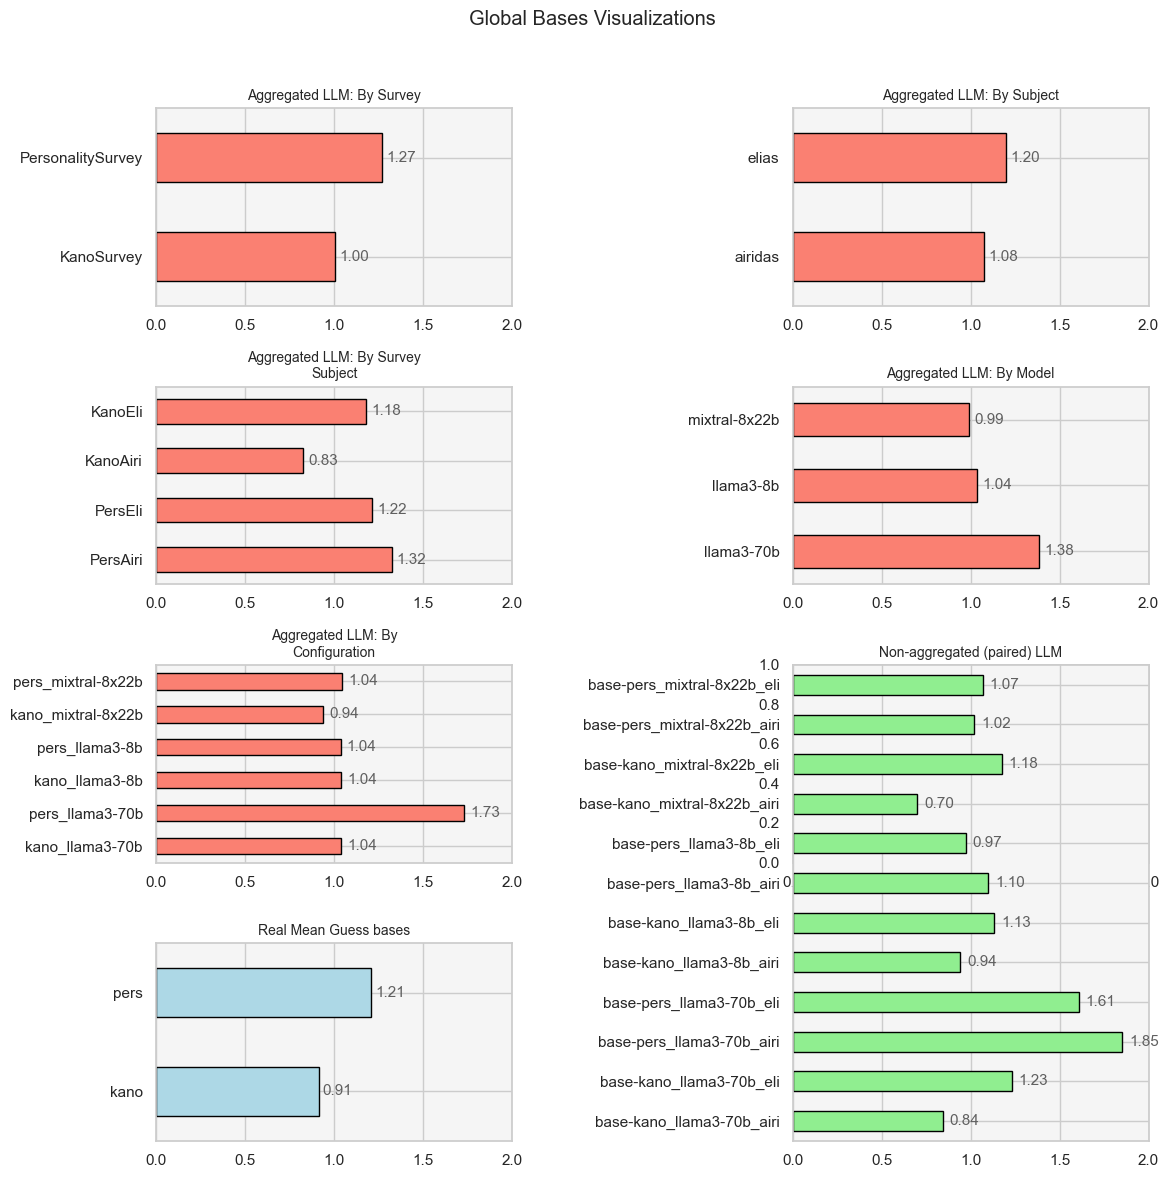

In [182]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 12))
fig.suptitle('Global Bases Visualizations')
gs = gridspec.GridSpec(4, 2)

# Define axes using the GridSpec
axs = {
    (0, 0): fig.add_subplot(gs[0, 0]),
    (0, 1): fig.add_subplot(gs[0, 1]),
    (1, 0): fig.add_subplot(gs[1, 0]),
    (1, 1): fig.add_subplot(gs[1, 1]),
    (2, 0): fig.add_subplot(gs[2, 0]),
    (2, 1): fig.add_subplot(gs[2, 1]),
    (3, 0): fig.add_subplot(gs[3, 0]),
    (3, 1): fig.add_subplot(gs[2:4, 1])  # Span 'Non-aggregated LLM' across two vertical spaces
}

# Data dictionary to align with subplot axes
plot_data = {
    (0, 0): ('by_survey', 'Aggregated LLM: By Survey', "salmon"),
    (0, 1): ('by_subject', 'Aggregated LLM: By Subject', "salmon"),
    (1, 0): ('by_survey_subject', 'Aggregated LLM: By Survey Subject', "salmon"),
    (1, 1): ('by_model', 'Aggregated LLM: By Model', "salmon"),
    (2, 0): ('by_simulation', 'Aggregated LLM: By Configuration', "salmon"),
    (3, 0): ('mean_guess', 'Real Mean Guess bases', "lightblue"),
    (3, 1): ('atomic', 'Non-aggregated (paired) LLM', "lightgreen")
}

# Loop through to plot each graph
for pos, (key, title, color) in plot_data.items():
    ax = axs[pos]
    title_text = textwrap.fill(title, width=30)  
    ax.set_title(title_text, fontsize=10)

    if key == 'master':
        ax.barh('Master', global_base_scores[key], color=color, edgecolor='black', linewidth=1)
    else: 
        df = pd.DataFrame.from_dict(global_base_scores[key], orient='index', columns=['Value'])
        bars = df.plot.barh(ax=ax, legend=False, color=color, edgecolor='black', linewidth=1)
        
        # Add value annotations to each bar
        for bar in bars.patches:
            bar_value = bar.get_width()
            ax.text(bar.get_width() + df['Value'].max()*0.02, bar.get_y() + bar.get_height()/2, 
                    f'{bar_value:.2f}', va='center', ha='left', color='#606060', fontsize=11)
            
    # Style adjustments
    ax.set_facecolor('#f5f5f5')
    ax.set_xlim(0, 2.0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Vizualisation

In [183]:
# Inspects the columns in text format

IGNORE_COLS = ["date", "EMBED_MODEL", "avg_tokens_in_prompt", "chunk_count", "OVERLAP_SIZE", "RETRIEVAL_PROMPT", "SIMULATION_ID", "path", "survey", ]
for col in dfg.columns:
    if col in IGNORE_COLS:
        continue  # Skip the columns from the IGNORE_COLS list
    dtype = dfg[col].dtype
    uniq_vals = dfg[col].unique()
    uniq_count = len(uniq_vals)
    na_count = dfg[col].isna().sum()
    print(f"{col}, dtype: {dtype}, unique count: {uniq_count}, NA values: {na_count}", end="")
    
    # Condition to check length of unique values and print them if < 5 and each < 25 chars
    if uniq_count < 8 and all(len(str(val)) <= 150 for val in uniq_vals):
        print(f", Unique values: {uniq_vals}", end="")
    print()

sim_signature, dtype: object, unique count: 78, NA values: 0
MAE, dtype: float64, unique count: 57, NA values: 6
MAE_base, dtype: float64, unique count: 13, NA values: 6
dMAE, dtype: float64, unique count: 59, NA values: 6
dMAE_airi, dtype: float64, unique count: 56, NA values: 6
dMAE_eli, dtype: float64, unique count: 61, NA values: 6
model, dtype: object, unique count: 3, NA values: 0, Unique values: ['llama3-70b' 'llama3-8b' 'mixtral-8x22b']
survey_type, dtype: object, unique count: 2, NA values: 0, Unique values: ['KanoSurvey' 'PersonalitySurvey']
base_sim_signature, dtype: object, unique count: 7, NA values: 0, Unique values: ['base-kano-29_llama3-70b_V7' 'base-kano-29_llama3-8b_V7'
 'base-kano-29_mixtral-8x22b_V7' 'base-pers-29_llama3-70b_V7'
 'base-pers-29_llama3-8b_V7' 'base-pers-29_mixtral-8x22b_V7' '(base)']
SUBJECT, dtype: object, unique count: 3, NA values: 0, Unique values: ['airidas' '(base)' 'elias']
CTX_limit, dtype: object, unique count: 4, NA values: 0, Unique values:

#### MAE

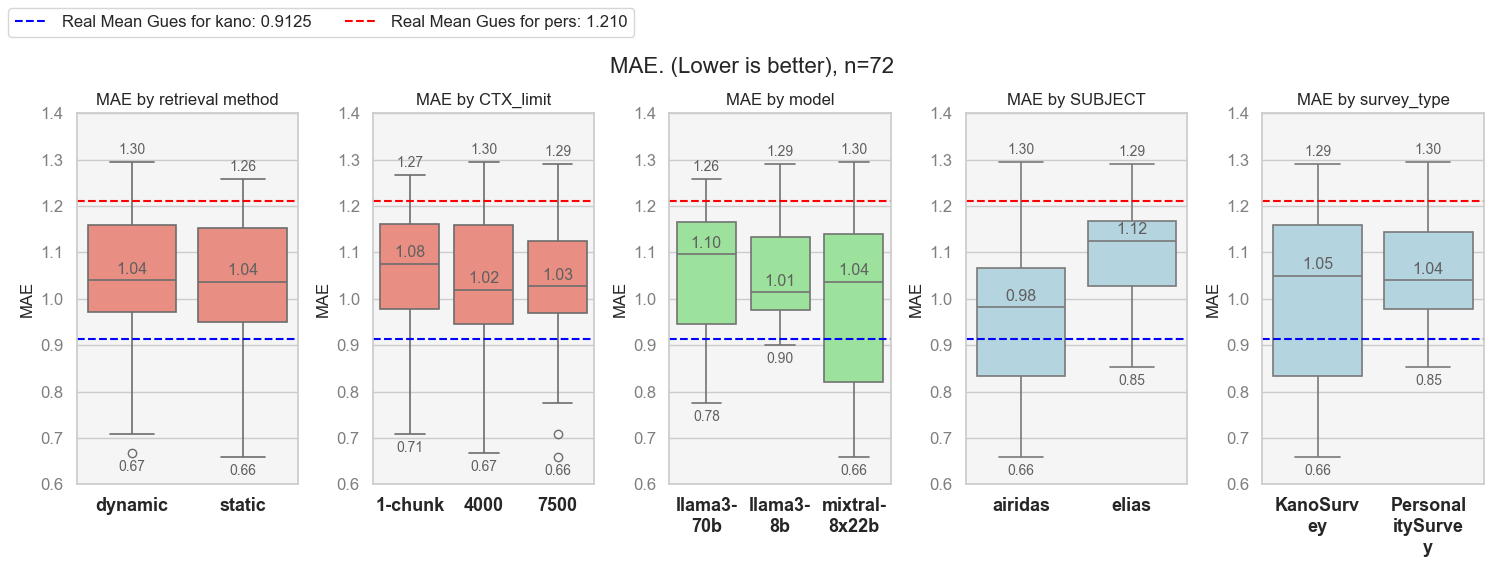

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your dataframe is named `dfg`
plt.figure(figsize=(15, 5))

filtered_df = dfg[dfg['is_base'] == False]
parameters = ['retrieval method', 'CTX_limit', 'model', 'SUBJECT', 'survey_type']

lines, labels = [], [] # To keep track of legend handles
for i, param in enumerate(parameters, 1):
    ax = plt.subplot(1, 5, i)
    ax.grid(True)
    color = getGlobalColorByParam(param)
    sns.boxplot(x=param, y='MAE', color=color, data=filtered_df, ax=ax, linewidth=1.2)
    #### Extract median values and their positions ######
    grouped_data = filtered_df.groupby(param)['MAE']
    add_value_texts(grouped_data, ax)
    #####################################################
    
    plt.title(f'MAE by {param}')
    plt.ylabel('MAE')
    plt.xticks(rotation=0) 
    plt.ylim(bottom=0.6, top=1.35)
    super_format_ax(ax)

    # Adding horizontal lines for guidelines
    line1, line2 = plt.axhline(y=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')
    if i == 1:  # Only need these once for creating the legend
        lines.extend([line1, line2])
        labels.extend(['Real Mean Gues for kano: 0.9125', 'Real Mean Gues for pers: 1.210'])

for ax in plt.gcf().axes:  # Go over all subplots in the figure
    ax.set_xlabel('') 
plt.tight_layout()
plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=12)
plt.suptitle(f'\n\nMAE. (Lower is better), n={len(filtered_df)}', y=1.13, fontsize=16) 
plt.show()

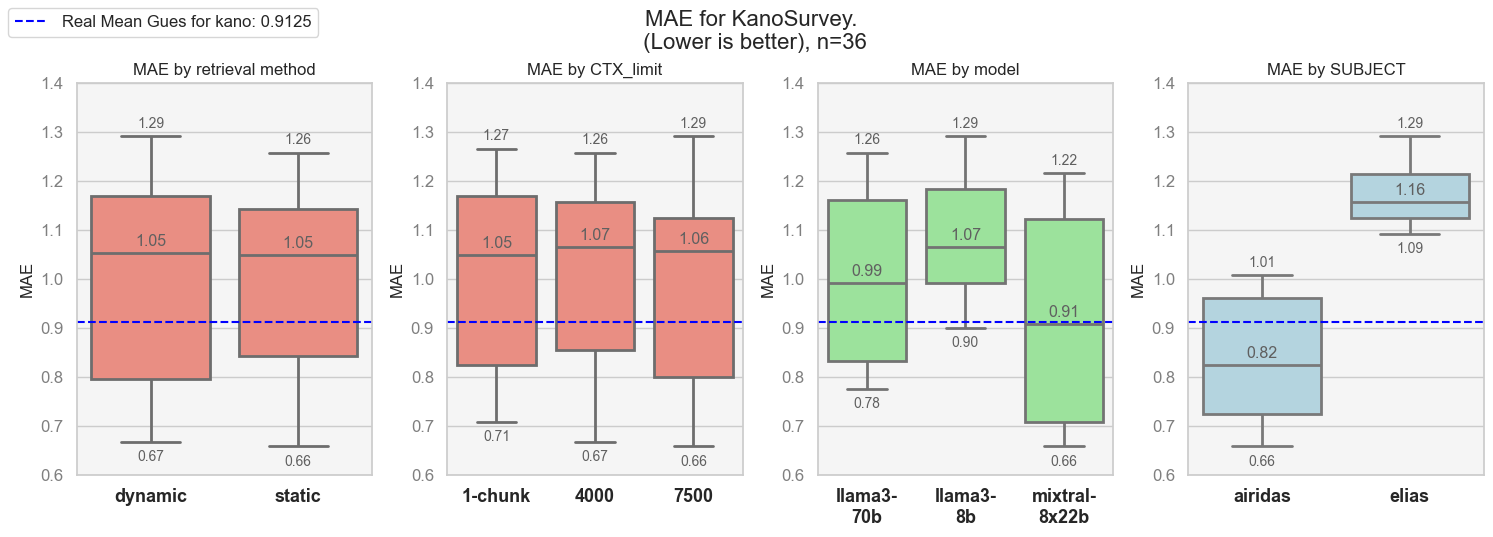

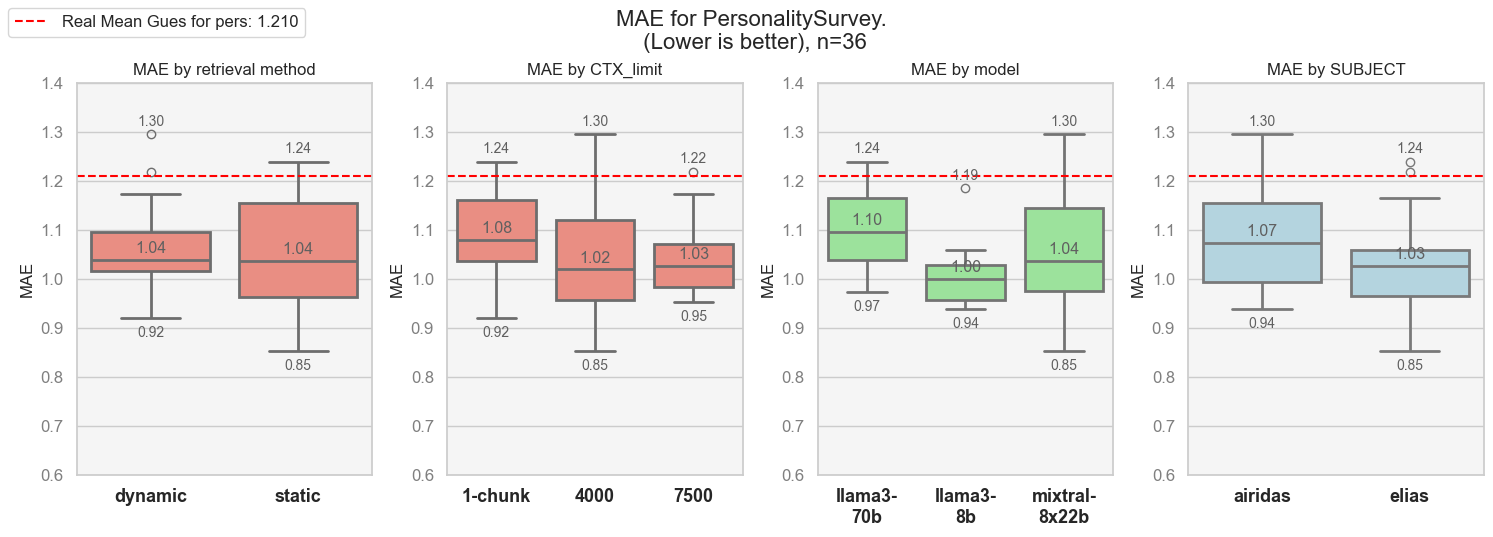

In [546]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap


# Assuming your dataframe is named `df`
for srv in ['KanoSurvey', "PersonalitySurvey"]:
    plt.figure(figsize=(15, 5))
    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv)]
    parameters = ['retrieval method', 'CTX_limit', 'model', 'SUBJECT']
    
    lines, labels = [], [] # To keep track of legend handles
    for i, param in enumerate(parameters, 1):
        ax = plt.subplot(1, 4, i)
        ax.grid(True)
        
        color = getGlobalColorByParam(param)
        sns.boxplot(x=param, y='MAE', color=color, data=filtered_df, ax=ax, linewidth=2)
        #### Extract median values and their positions ######
        grouped_data = filtered_df.groupby(param)['MAE']
        add_value_texts(grouped_data, ax)
        #####################################################
        
        plt.title(f'MAE by {param}')
        plt.ylabel('MAE')
        plt.xticks(rotation=0) 
        plt.ylim(bottom=0.6, top=1.35)
        super_format_ax(ax)

        # Adding horizontal lines for guidelines
        if srv == 'KanoSurvey':
            lines_new = [plt.axhline(y=0.9125, color='blue', linestyle='--')]
            labels_new = ['Real Mean Gues for kano: 0.9125']
        elif srv == 'PersonalitySurvey':
            lines_new = [plt.axhline(y=1.210, color='red', linestyle='--')]
            labels_new = ['Real Mean Gues for pers: 1.210']
        else:
            lines_new = [plt.axhline(y=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')]
            labels_new = ['Real Mean Guess for Kano: 0.9125', 'Real Mean Guess for pers: 1.210']
        
        if i == 1:  # Only need these once for creating the legend
            lines.extend(lines_new)
            labels.extend(labels_new)

    for ax in plt.gcf().axes:  # Go over all subplots in the figure
        ax.set_xlabel('') 
    plt.tight_layout()
    plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=12)
    plt.suptitle(f'MAE for {srv}.\n (Lower is better), n={len(filtered_df)}', y=1.07, fontsize=16) 
    plt.show()


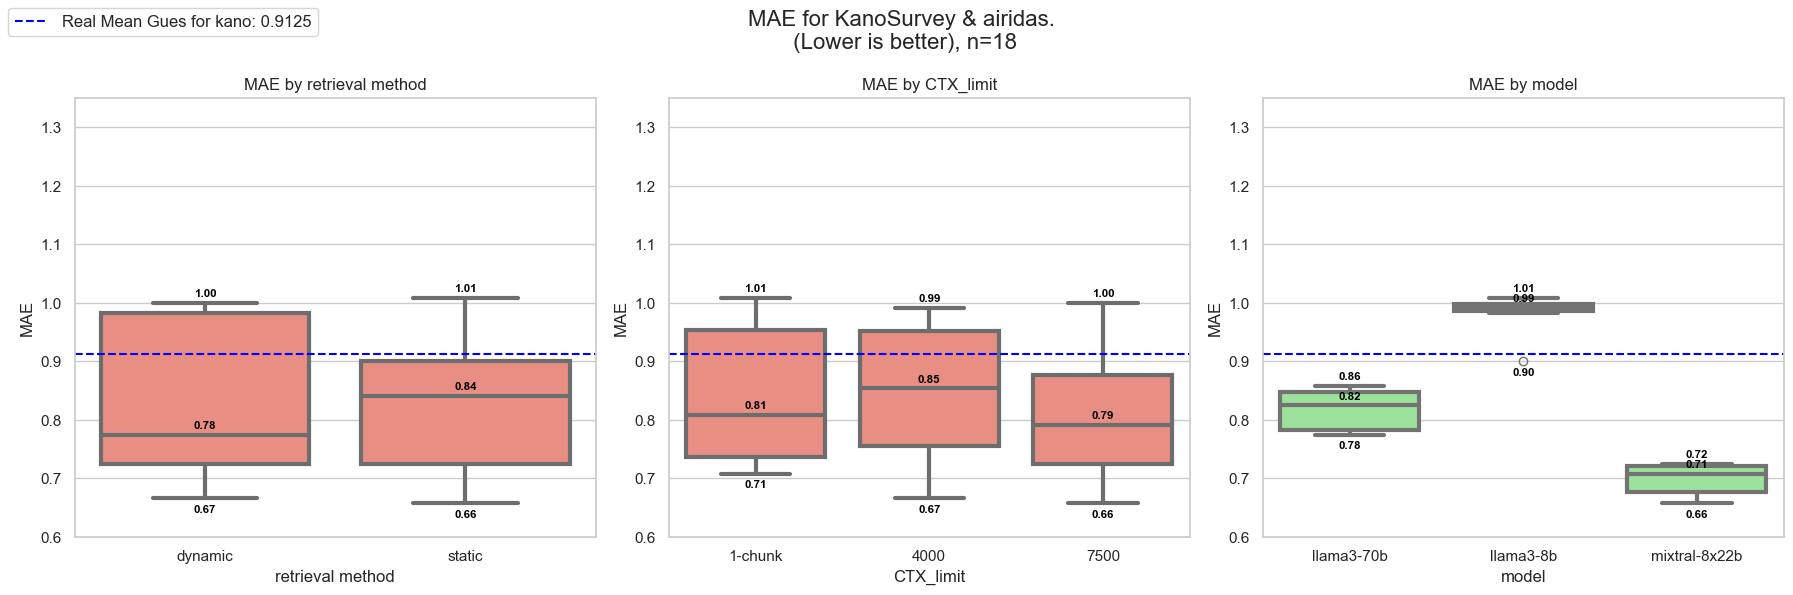

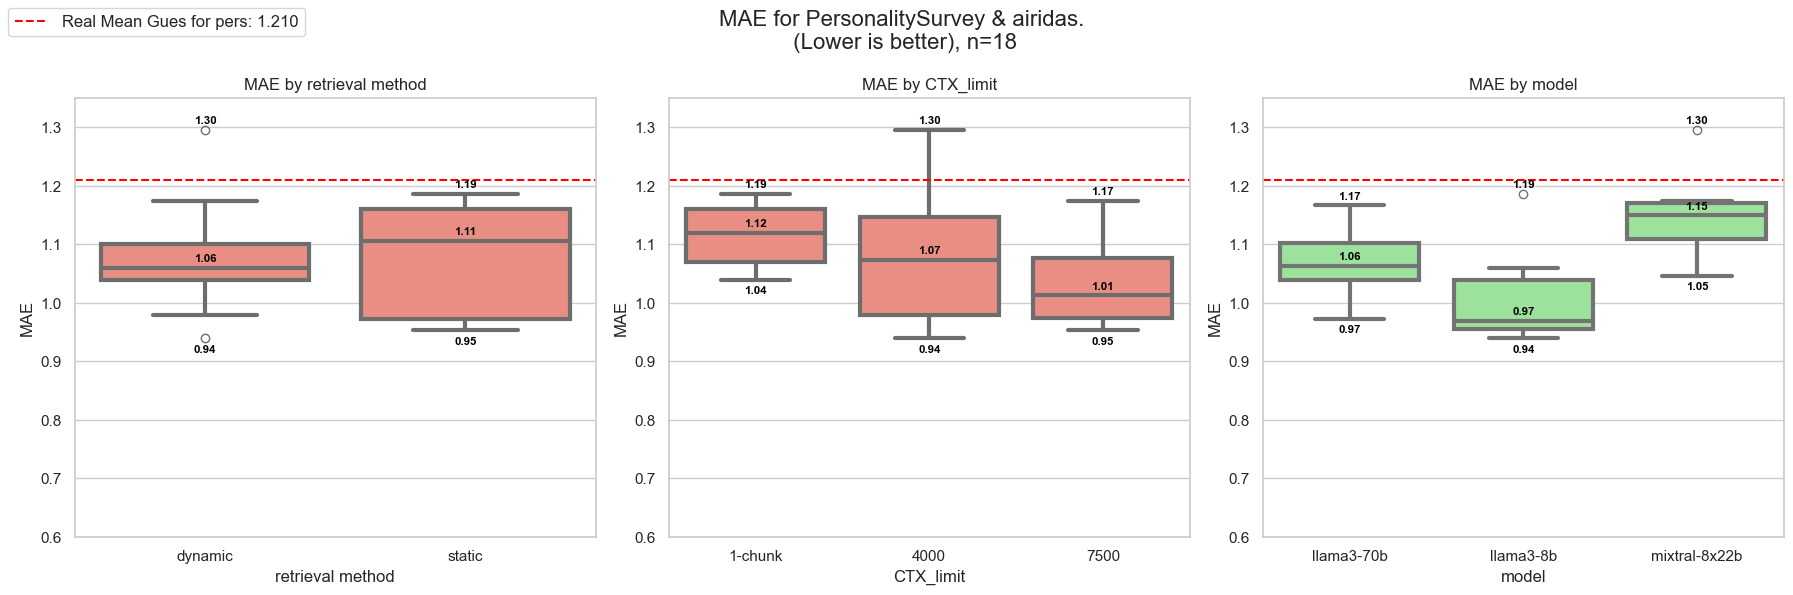

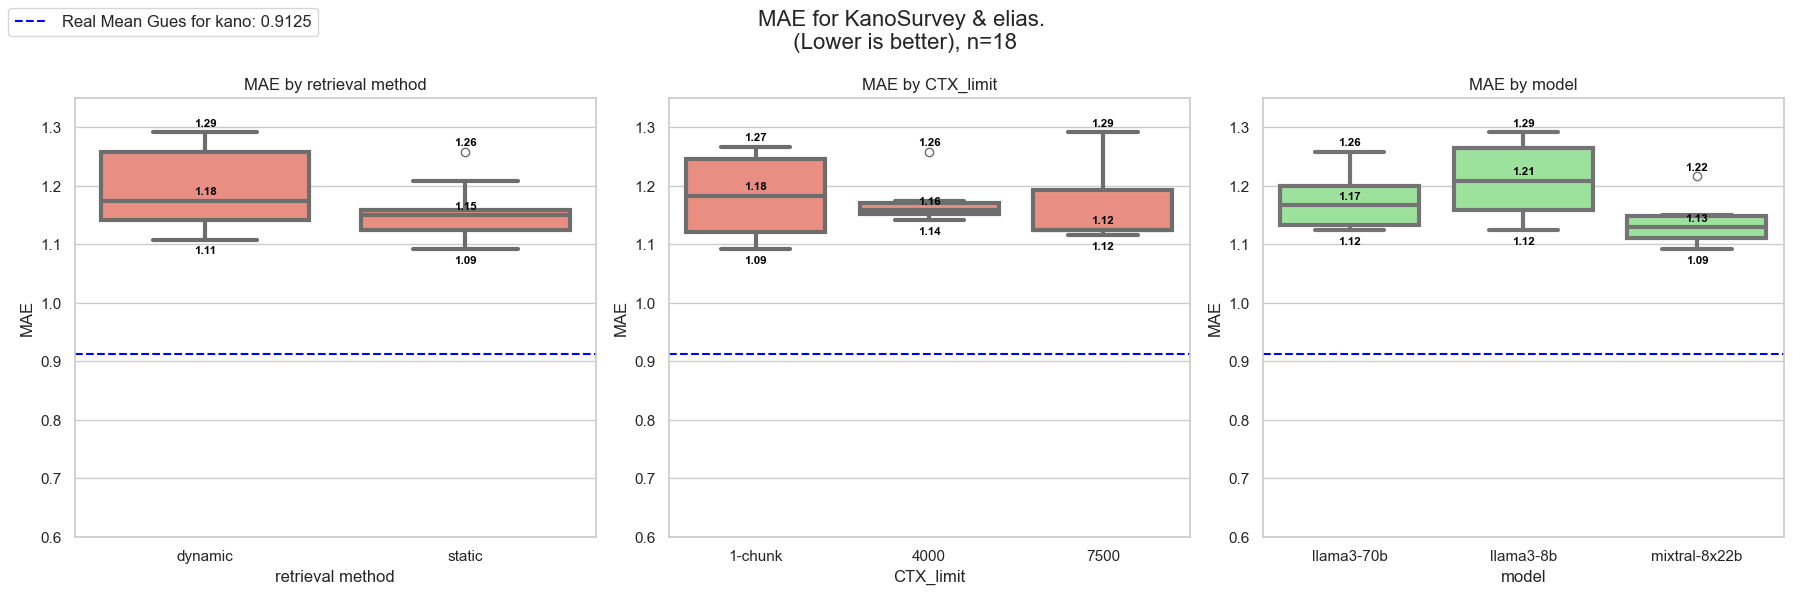

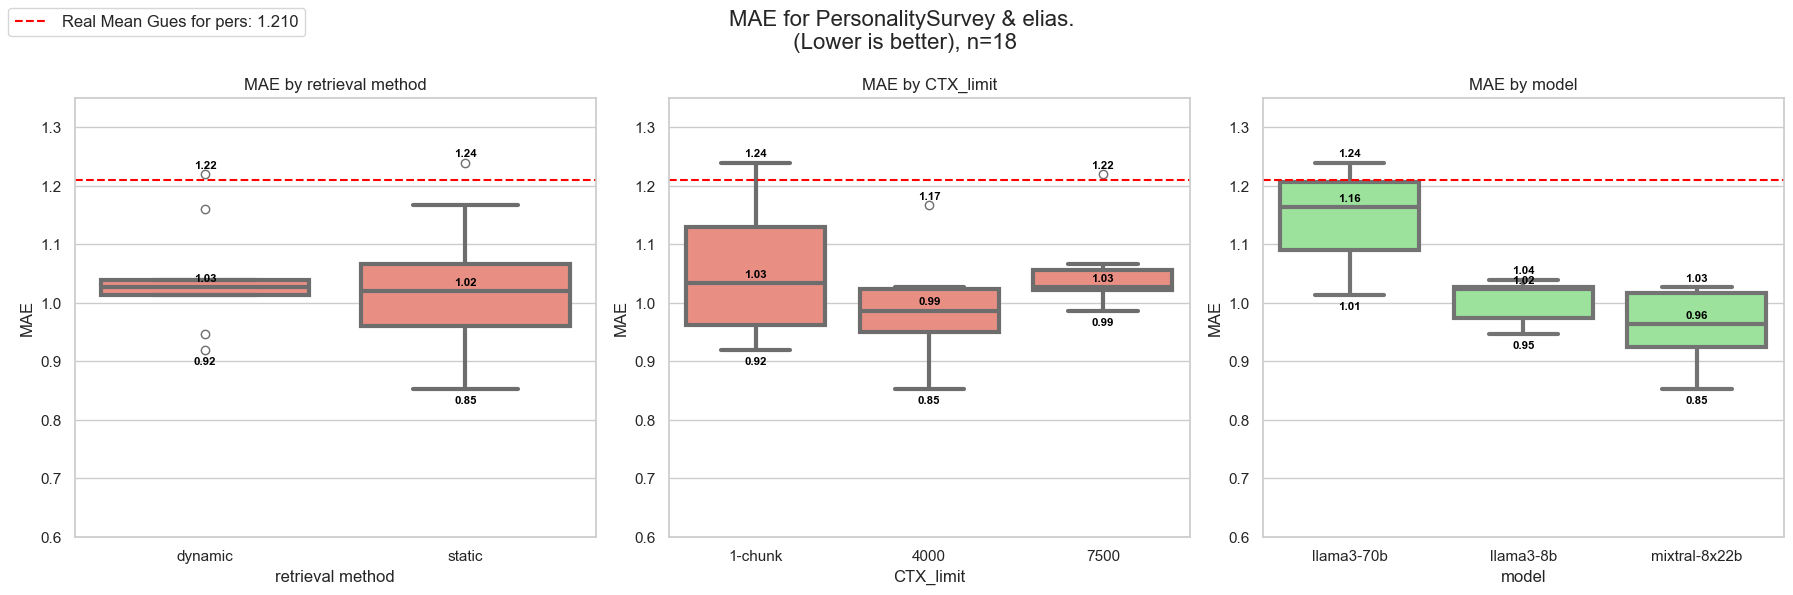

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named `df`
for subj in ['airidas', 'elias']:
    for srv in ['KanoSurvey', "PersonalitySurvey"]:
        plt.figure(figsize=(18, 10))
        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv) & (dfg['SUBJECT'] == subj)]
        parameters = ['retrieval method', 'CTX_limit', 'model']
        
        lines, labels = [], [] # To keep track of legend handles
        for i, param in enumerate(parameters, 1):
            ax = plt.subplot(2, 3, i)
            ax.grid(True)
            
            color = getGlobalColorByParam(param)
            sns.boxplot(x=param, y='MAE', color=color, data=filtered_df, ax=ax, linewidth=3)
            #### Extract median values and their positions ######
            grouped_data = filtered_df.groupby(param)['MAE']
            mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
            pos = range(len(mins))  # Positions of the boxplots
            vertical_offset = 0.01  # offset each text to avoid clutter
            for tick in pos:
                ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            #####################################################
            
            plt.title(f'MAE by {param}')
            plt.ylabel('MAE')
            plt.xticks(rotation=0) 
            plt.ylim(bottom=0.6, top=1.35) 

            # Adding horizontal lines for guidelines
            if srv == 'KanoSurvey':
                lines_new = [plt.axhline(y=0.9125, color='blue', linestyle='--')]
                labels_new = ['Real Mean Gues for kano: 0.9125']
            elif srv == 'PersonalitySurvey':
                lines_new = [plt.axhline(y=1.210, color='red', linestyle='--')]
                labels_new = ['Real Mean Gues for pers: 1.210']
            else:
                lines_new = [plt.axhline(y=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')]
                labels_new = ['Real Mean Guess for Kano: 0.9125', 'Real Mean Guess for pers: 1.210']
            
            if i == 1:  # Only need these once for creating the legend
                lines.extend(lines_new)
                labels.extend(labels_new)
        plt.tight_layout()
        plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=12)
        plt.suptitle(f'MAE for {srv} & {subj}.\n (Lower is better), n={len(filtered_df)}', y=1.05, fontsize=16)
        plt.show()

### dMAE: New

#### Big boy - All 5

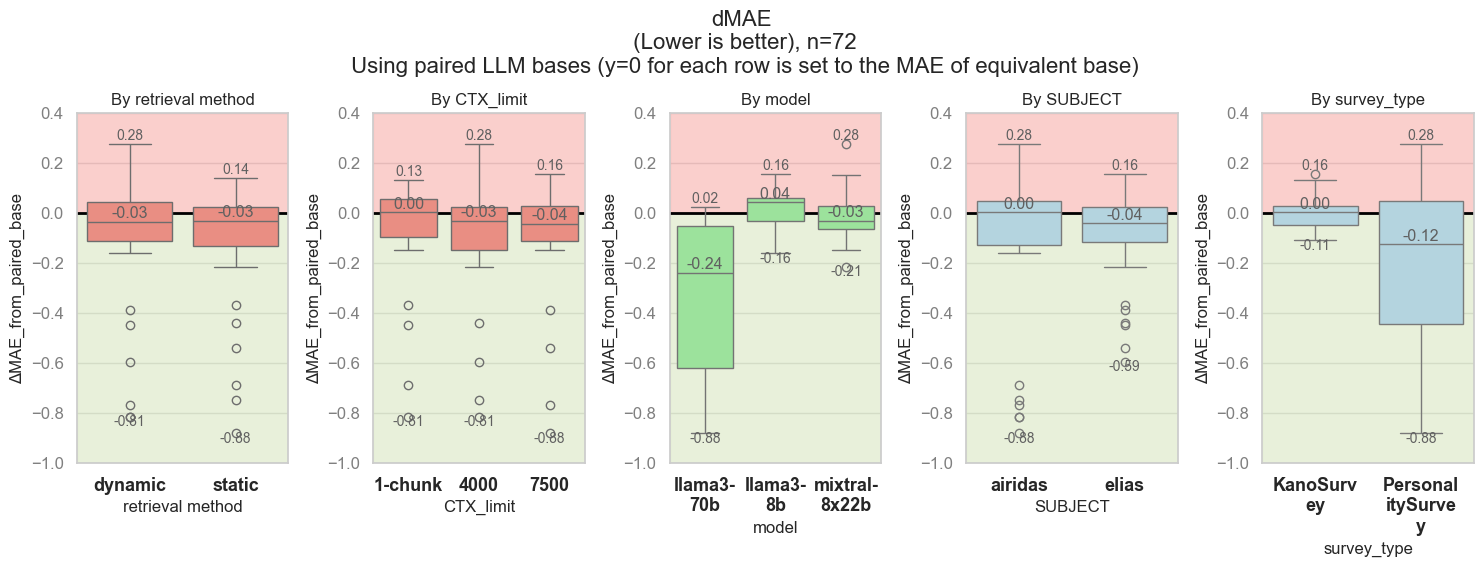

In [187]:
plt.figure(figsize=(15, 5))
filtered_df = dfg[dfg['is_base'] == False]
parameters = ['retrieval method', 'CTX_limit', 'model',  'SUBJECT', 'survey_type',]
base_val = global_base_scores["master"]
base_name = "master"
for index, sim_row in dfg.iterrows():
    for key, value_name in compare_to_custom_base(sim_row, base_val=base_val, base_name=base_name).items():
        dfg.at[index, key] = value_name

lines, labels = [], [] # To keep track of legend handles
for i, param in enumerate(parameters):
    ax = plt.subplot(1, 5, i + 1)  # Horizontal layout of plots
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=2) 
    ax.axhspan(-1, 0, color='#dcedc1', alpha=0.5)  # Stylish green background below zero
    ax.axhspan(0, 0.5, color='#ffaaa5', alpha=0.5)   # Stylish red background above zero    # Background color above zero
    color = getGlobalColorByParam(param)
    #### Extract median values and their positions ######
    grouped_data = filtered_df.groupby(param)['dMAE']
    mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
    pos = range(len(mins))  # Positions of the boxplots
    vertical_offset = 0.01  # offset each text to avoid clutter
    
    # for tick in pos:
    #     ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    #     ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    #     ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    #####################################################
    sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
    plt.title(f'By {param}')
    plt.ylabel(f'ΔMAE_from_paired_base')
    plt.xticks(rotation=0) 
    plt.ylim(bottom=-0.95, top=0.32)  # Adjust y-limits


    super_format_ax(ax)
    add_value_texts(grouped_data, ax)
plt.tight_layout()
plt.suptitle(f'dMAE\n (Lower is better), n={len(filtered_df)}\n Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.13, fontsize=16) 
plt.show()

#### Four

In [ ]:
parameters = ['retrieval method', 'CTX_limit', 'SUBJECT', 'survey_type',]
for models in [['llama3-70b'], ['llama3-8b'], ['mixtral-8x22b']]:
    plt.figure(figsize=(18, 6))
    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'].isin(models))]
    for i, param in enumerate(parameters):
        ax = plt.subplot(1, 4, i + 1)  # Horizontal layout of plots
        ax.grid(True)
        ax.axhline(0, color='black', linewidth=2) 
        ax.axhspan(-1, 0, color='green', alpha=0.16)  # Stylish green background below zero
        ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
        color = getGlobalColorByParam(param)
        #### Extract median values and their positions ######
        grouped_data = filtered_df.groupby(param)['dMAE']
        mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
        pos = range(len(mins))  # Positions of the boxplots
        vertical_offset = 0.01  # offset each text to avoid clutter
        for tick in pos:
            ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
        #####################################################
        sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
        plt.title(f'By {param}')
        plt.ylabel(f'dMAE')
        plt.xticks(rotation=0) 
        plt.ylim(bottom=-0.3, top=0.32)  # Adjust y-limits
    plt.tight_layout()
    plt.suptitle(f'dMAE for {models}\n (Lower is better), n={len(filtered_df)}\n Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.10, fontsize=16) 
    plt.show()

#### Three musketers (by subj)

In [ ]:
parameters = ['retrieval method', 'CTX_limit', 'survey_type']
for subj in ['airidas', 'elias']:
    for models in [['mixtral-8x22b']]:
        plt.figure(figsize=(12, 6))
        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'].isin(models)) & (dfg['SUBJECT'] == (subj))]
        for i, param in enumerate(parameters):
            ax = plt.subplot(1, 3, i + 1)  # Horizontal layout of plots
            ax.grid(True)
            ax.axhline(0, color='black', linewidth=2) 
            ax.axhspan(-1, 0, color='green', alpha=0.16)  # Stylish green background below zero
            ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
            color = getGlobalColorByParam(param)
            #### Extract median values and their positions ######
            grouped_data = filtered_df.groupby(param)['dMAE']
            mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
            pos = range(len(mins))  # Positions of the boxplots
            vertical_offset = 0.01  # offset each text to avoid clutter
            for tick in pos:
                ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            #####################################################
            sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
            plt.title(f'By {param}')
            plt.ylabel(f'dMAE')
            plt.xticks(rotation=0) 
            plt.ylim(bottom=-0.32, top=0.32)  # Adjust y-limits
        plt.tight_layout()
        plt.suptitle(f'dMAE for {models} for {subj}\n (Lower is better), n={len(filtered_df)}\n Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.10, fontsize=16) 
        plt.show()

#### Three musketers

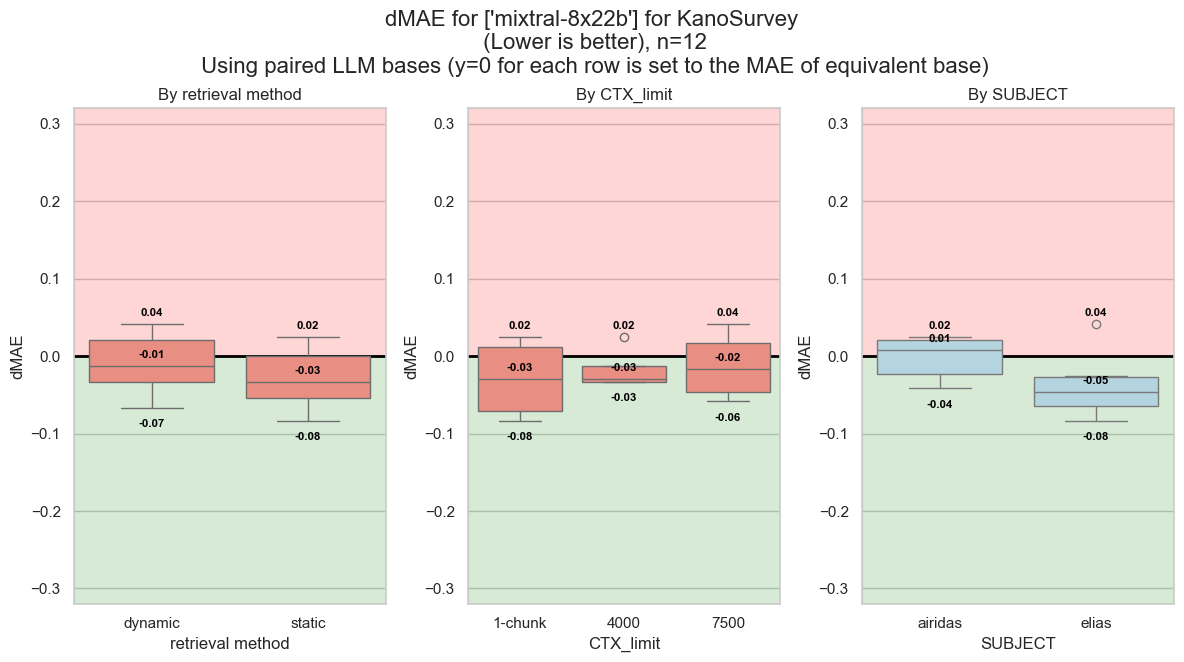

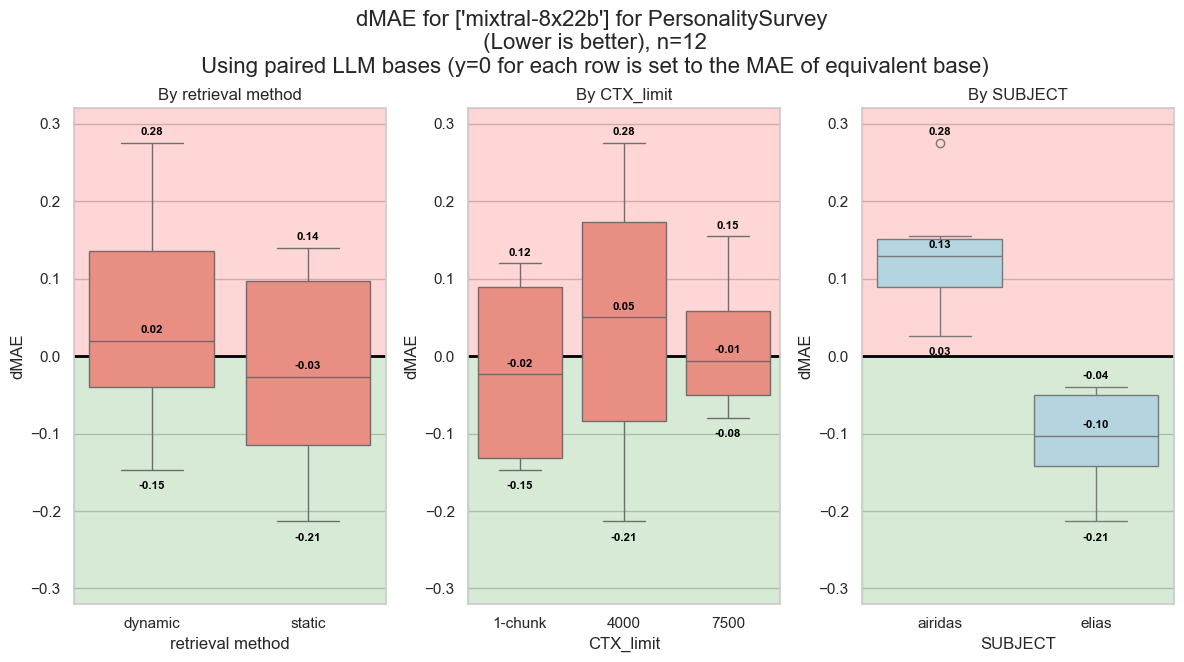

In [190]:
parameters = ['retrieval method', 'CTX_limit', 'SUBJECT']
for srv in ['KanoSurvey', "PersonalitySurvey"]:
    for models in [['mixtral-8x22b']]:
        plt.figure(figsize=(12, 6))
        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'].isin(models)) & (dfg['survey_type'] == (srv))]
        for i, param in enumerate(parameters):
            ax = plt.subplot(1, 3, i + 1)  # Horizontal layout of plots
            ax.grid(True)
            ax.axhline(0, color='black', linewidth=2) 
            ax.axhspan(-1, 0, color='green', alpha=0.16)  # Stylish green background below zero
            ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
            color = getGlobalColorByParam(param)
            #### Extract median values and their positions ######
            grouped_data = filtered_df.groupby(param)['dMAE']
            mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
            pos = range(len(mins))  # Positions of the boxplots
            vertical_offset = 0.01  # offset each text to avoid clutter
            for tick in pos:
                ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            #####################################################
            sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
            plt.title(f'By {param}')
            plt.ylabel(f'dMAE')
            plt.xticks(rotation=0) 
            plt.ylim(bottom=-0.32, top=0.32)  # Adjust y-limits
        plt.tight_layout()
        plt.suptitle(f'dMAE for {models} for {srv}\n (Lower is better), n={len(filtered_df)}\n Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.10, fontsize=16) 
        plt.show()

#### Two Gangsters

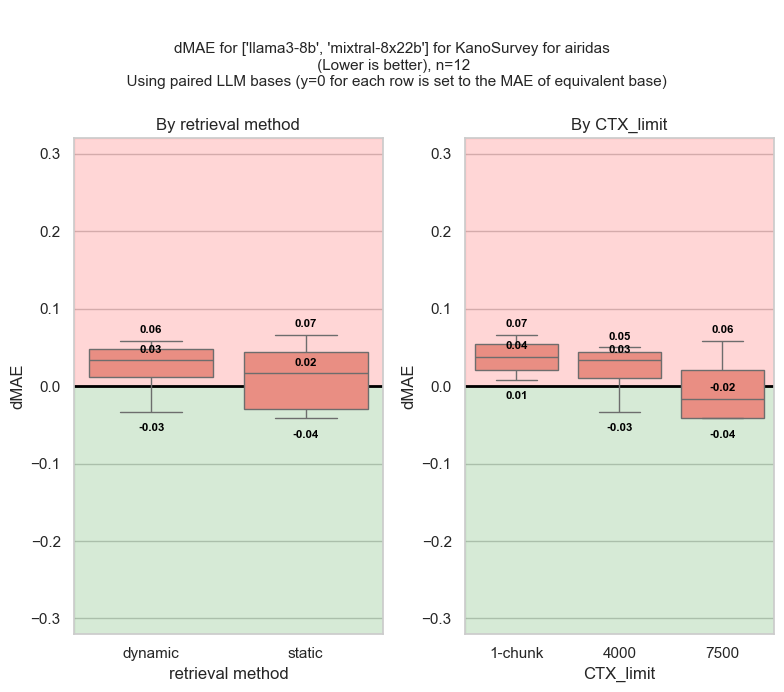

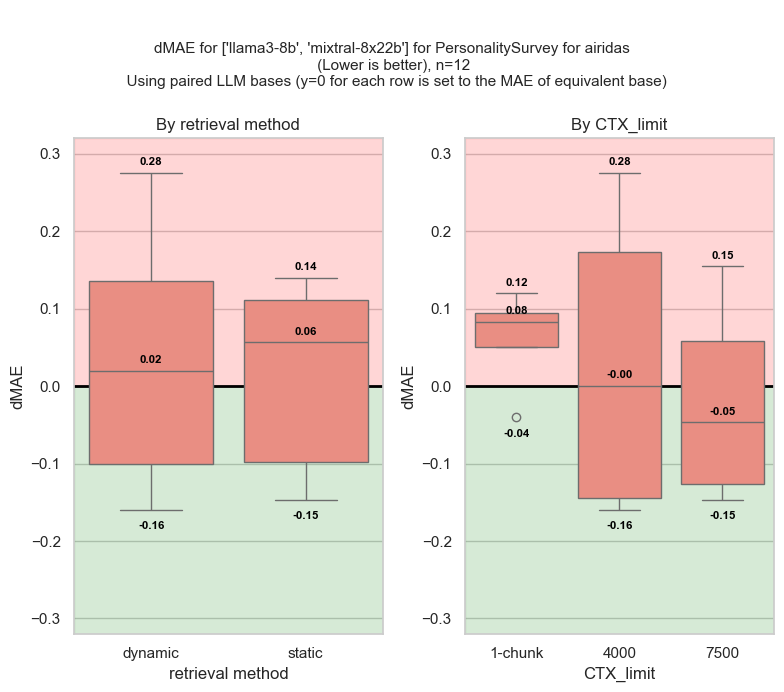

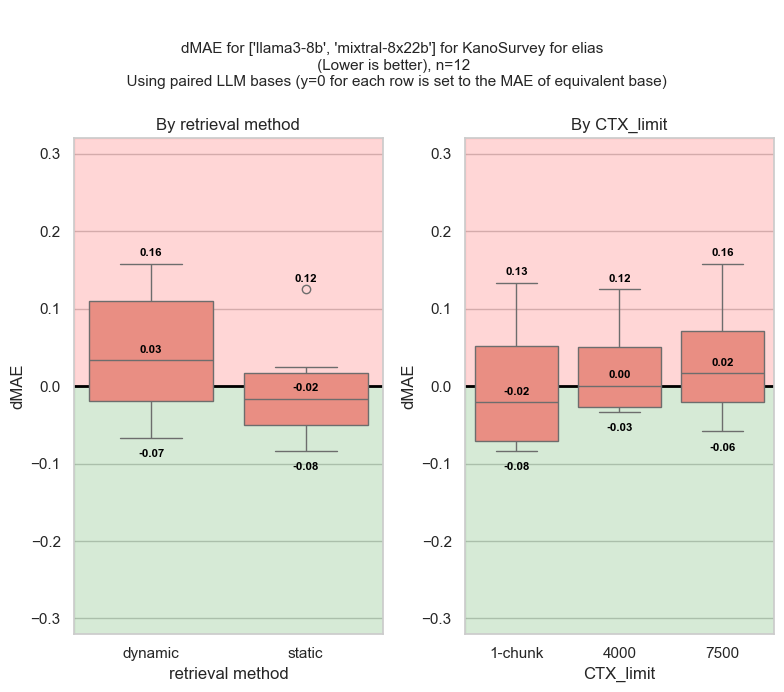

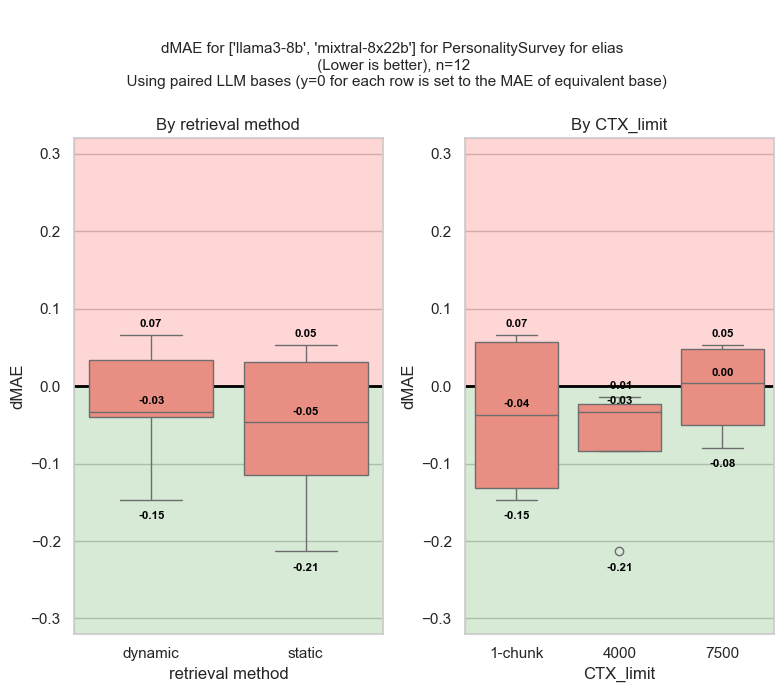

In [191]:
parameters = ['retrieval method', 'CTX_limit']
for subj in ['airidas', 'elias']:
    for srv in ['KanoSurvey', "PersonalitySurvey"]:
        for models in [["llama3-8b",'mixtral-8x22b']]:
            plt.figure(figsize=(8, 6))
            filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'].isin(models)) & (dfg['survey_type'] == (srv)) & (dfg['SUBJECT'] == (subj))]
            base_sign = filtered_df.iloc[0]["base_sim_signature"]
            base_name = utils.unclutterSignature(base_sign)
            if subj == 'airidas': base_val = dfg[(dfg['sim_signature'] == base_sign)]['MAE_airi'].mean()
            else: base_val = dfg[(dfg['sim_signature'] == base_sign)]['MAE_eli'].mean()

            lines, labels = [], [] # To keep track of legend handles
            for i, param in enumerate(parameters):
                ax = plt.subplot(1, 2, i + 1)  # Horizontal layout of plots
                ax.grid(True)
                ax.axhline(0, color='black', linewidth=2) 
                ax.axhspan(-1, 0, color='green', alpha=0.16)  # Stylish green background below zero
                ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
                color = getGlobalColorByParam(param)
                #### Extract median values and their positions ######
                grouped_data = filtered_df.groupby(param)['dMAE']
                mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
                pos = range(len(mins))  # Positions of the boxplots
                vertical_offset = 0.01  # offset each text to avoid clutter
                for tick in pos:
                    ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                    ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                    ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                #####################################################
                sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
                plt.title(f'By {param}')
                plt.ylabel(f'dMAE')
                plt.xticks(rotation=0) 
                plt.ylim(bottom=-0.32, top=0.32)  # Adjust y-limits
                
                # if len(models[0]) < 2:
                #     if srv == 'KanoSurvey':
                #         lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--', linewidth=2.5), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                #         labels_new = [f'ΔReal Mean Guess base for kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

                #     elif srv == 'PersonalitySurvey':
                #         lines_new = [plt.axhline(y=1.210 - base_val, color='red', linestyle='--', linewidth=2.5), plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--')]
                #         labels_new = [f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}',f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}']
                #     else:
                #         lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                #         labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

                # if i == 1:  # Only need these once for creating the legend
                #     lines.extend(lines_new)
                #     labels.extend(labels_new)

            # plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
            plt.tight_layout()
            plt.suptitle(f'\n\ndMAE for {models} for {srv} for {subj}\n (Lower is better), n={len(filtered_df)}\n  Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.15, fontsize=11) 
            plt.show()

### dMAE: Old

#### Big boy - All 5

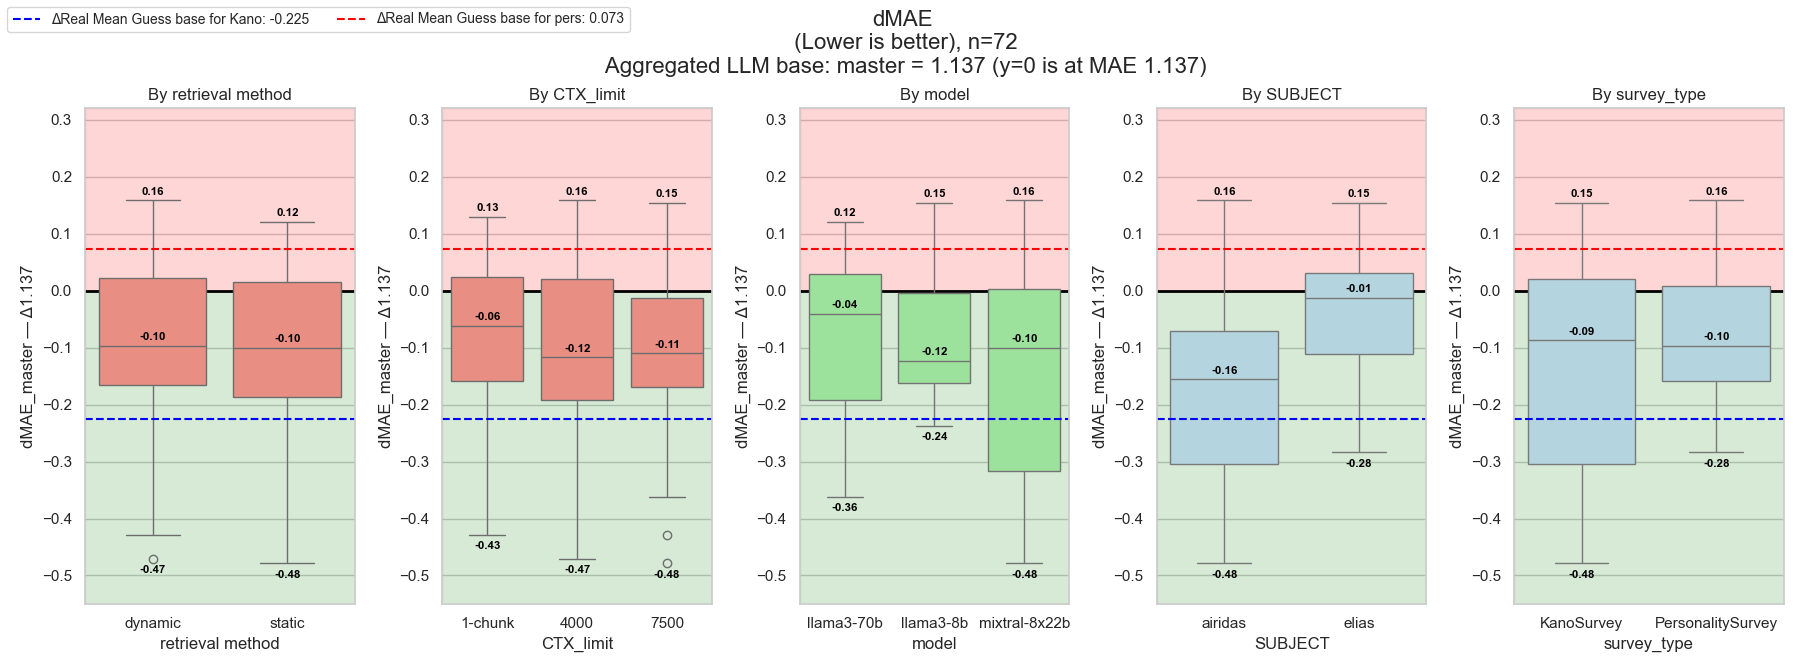

In [192]:
plt.figure(figsize=(18, 6))
filtered_df = dfg[dfg['is_base'] == False]
parameters = ['retrieval method', 'CTX_limit', 'model',  'SUBJECT', 'survey_type',]
base_val = global_base_scores["master"]
base_name = "master"
for index, sim_row in dfg.iterrows():
    for key, value_name in compare_to_custom_base(sim_row, base_val=base_val, base_name=base_name).items():
        dfg.at[index, key] = value_name

lines, labels = [], [] # To keep track of legend handles
for i, param in enumerate(parameters):
    ax = plt.subplot(1, 5, i + 1)  # Horizontal layout of plots
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=2) 
    ax.axhspan(-0.55, 0, color='green', alpha=0.16)  # Stylish green background below zero
    ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
    color = getGlobalColorByParam(param)
    #### Extract median values and their positions ######
    grouped_data = filtered_df.groupby(param)['dMAE_master']
    mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
    pos = range(len(mins))  # Positions of the boxplots
    vertical_offset = 0.01  # offset each text to avoid clutter
    for tick in pos:
        ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
        ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
        ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    #####################################################
    sns.boxplot(x=param, y=f'dMAE_{base_name}', color=color, data=filtered_df)
    plt.title(f'By {param}')
    plt.ylabel(f'dMAE_{base_name} — Δ{round(base_val,3)}')
    plt.xticks(rotation=0) 
    plt.ylim(bottom=-0.55, top=0.32)  # Adjust y-limits

    lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
    labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

    if i == 1:  # Only need these once for creating the legend
        lines.extend(lines_new)
        labels.extend(labels_new)

plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
plt.tight_layout()
plt.suptitle(f'dMAE\n (Lower is better), n={len(filtered_df)}\n Aggregated LLM base: {base_name} = {round(base_val,3)} (y=0 is at MAE {round(base_val,3)})', y=1.10, fontsize=16) 
plt.show()

#### Four

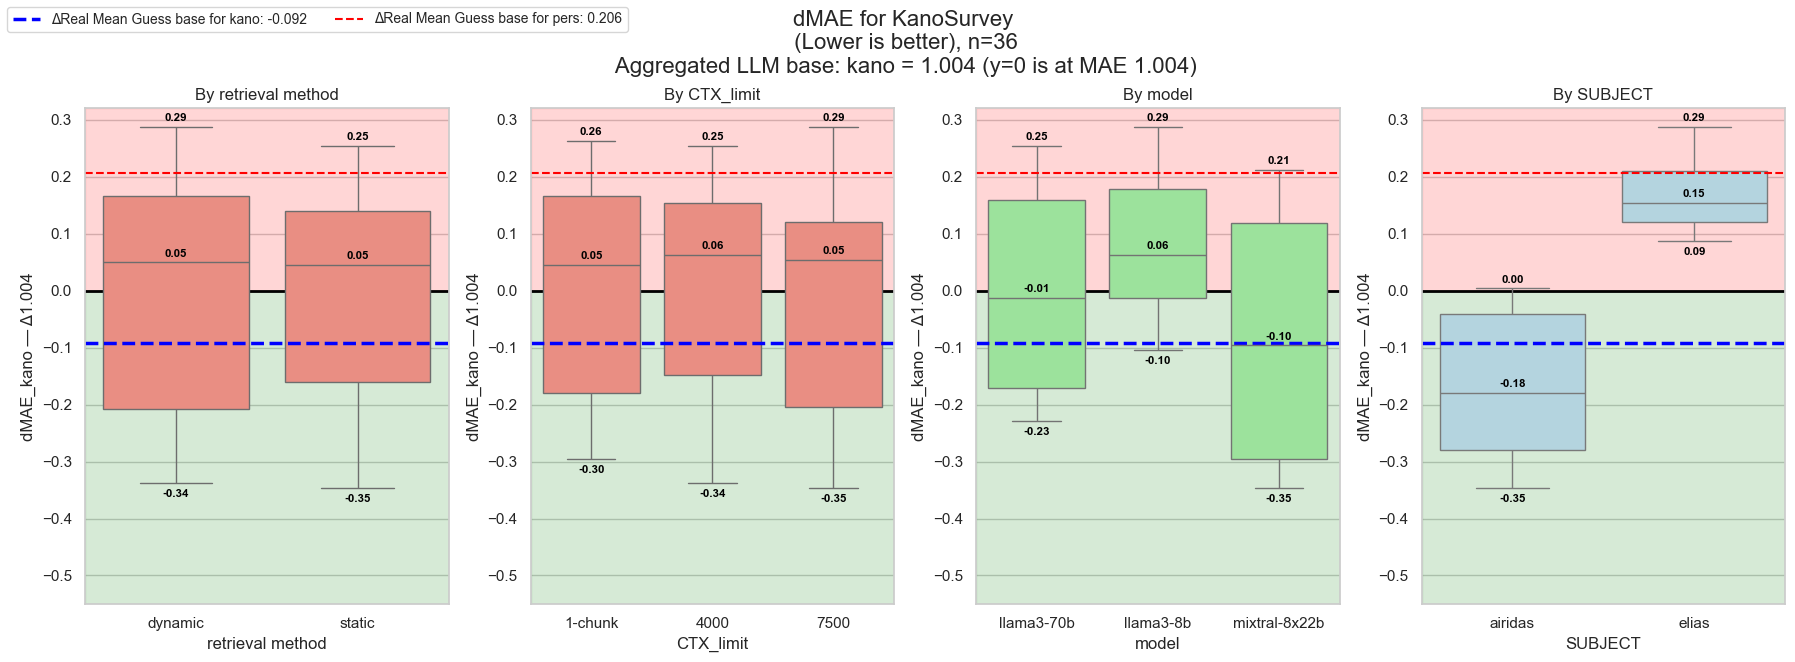

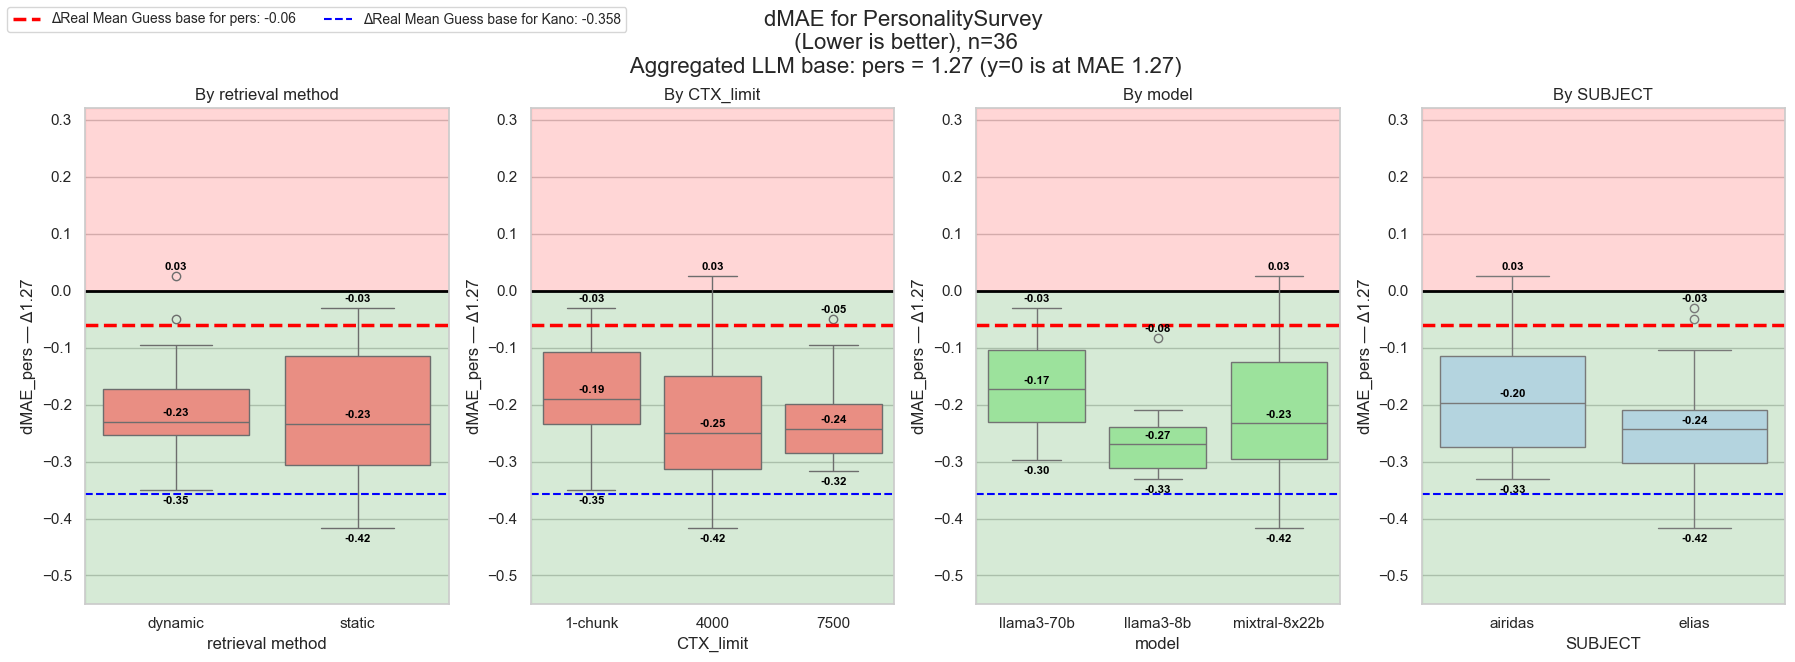

In [193]:
for srv in ['KanoSurvey', "PersonalitySurvey"]:
    base_val = global_base_scores["by_survey"][srv]
    base_name = srv[:4].lower()
    for index, sim_row in dfg.iterrows():
        for key, value_name in compare_to_custom_base(sim_row, base_val=base_val, base_name=base_name).items():
            dfg.at[index, key] = value_name

    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv)]
    parameters = ['retrieval method', 'CTX_limit',  'model','SUBJECT',]
    plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts
    lines, labels = [], [] # To keep track of legend handles
    for i, param in enumerate(parameters):
        ax = plt.subplot(1, 4, i + 1)  # Horizontal layout of plots
        ax.grid(True)
        ax.axhline(0, color='black', linewidth=2) 
        ax.axhspan(-0.55, 0, color='green', alpha=0.16)  # Stylish green background below zero
        ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
        color = getGlobalColorByParam(param)
        #### Extract median values and their positions ######
        grouped_data = filtered_df.groupby(param)[f'dMAE_{base_name}']
        mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
        pos = range(len(mins))  # Positions of the boxplots
        vertical_offset = 0.01  # offset each text to avoid clutter
        for tick in pos:
            ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
        #####################################################
        sns.boxplot(x=param, y=f'dMAE_{base_name}', color=color, data=filtered_df)
        plt.title(f'By {param}')
        plt.ylabel(f'dMAE_{base_name} — Δ{round(base_val,3)}')
        plt.xticks(rotation=0) 
        plt.ylim(bottom=-0.55, top=0.32)  # Adjust y-limits
        
        if srv == 'KanoSurvey':
            lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--', linewidth=2.5), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
            labels_new = [f'ΔReal Mean Guess base for kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

        elif srv == 'PersonalitySurvey':
            lines_new = [plt.axhline(y=1.210 - base_val, color='red', linestyle='--', linewidth=2.5), plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--')]
            labels_new = [f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}',f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}']
        else:
            lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
            labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

        if i == 1:  # Only need these once for creating the legend
            lines.extend(lines_new)
            labels.extend(labels_new)
    
    plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
    plt.tight_layout()
    plt.suptitle(f'dMAE for {srv}\n (Lower is better), n={len(filtered_df)}\n Aggregated LLM base: {base_name} = {round(base_val,3)} (y=0 is at MAE {round(base_val,3)})', y=1.10, fontsize=16) 
    plt.show()

#### Three Musketers

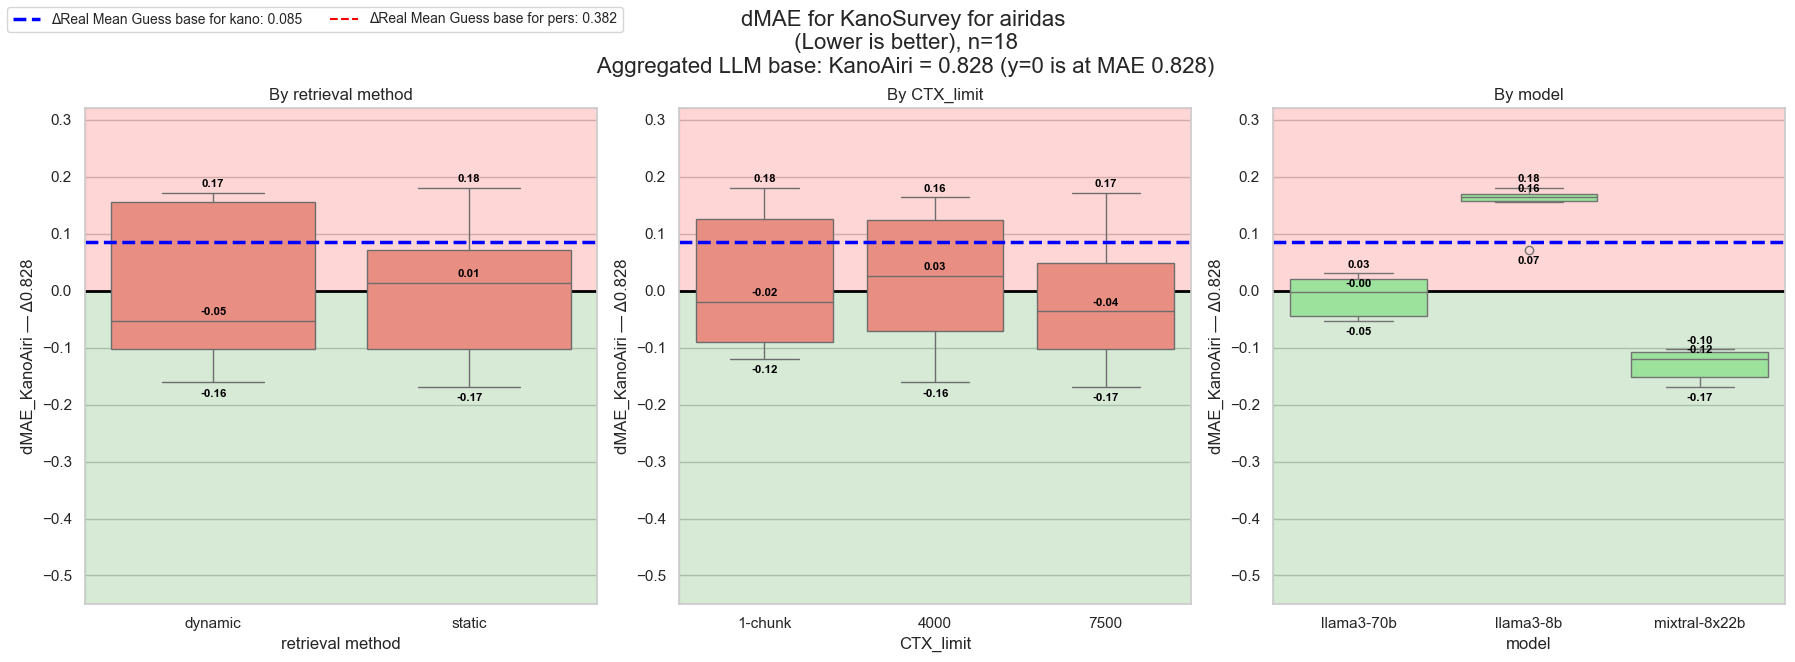

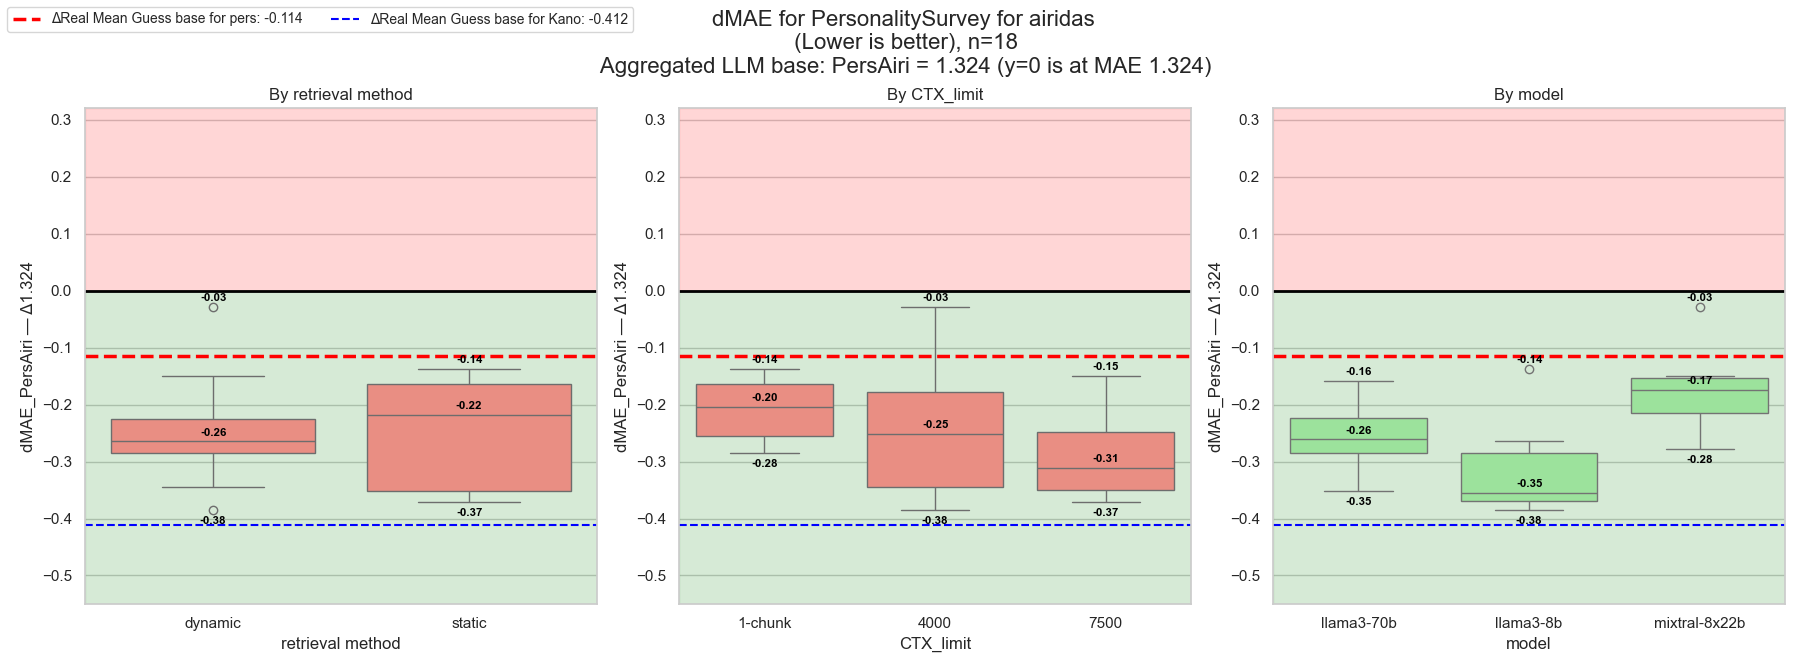

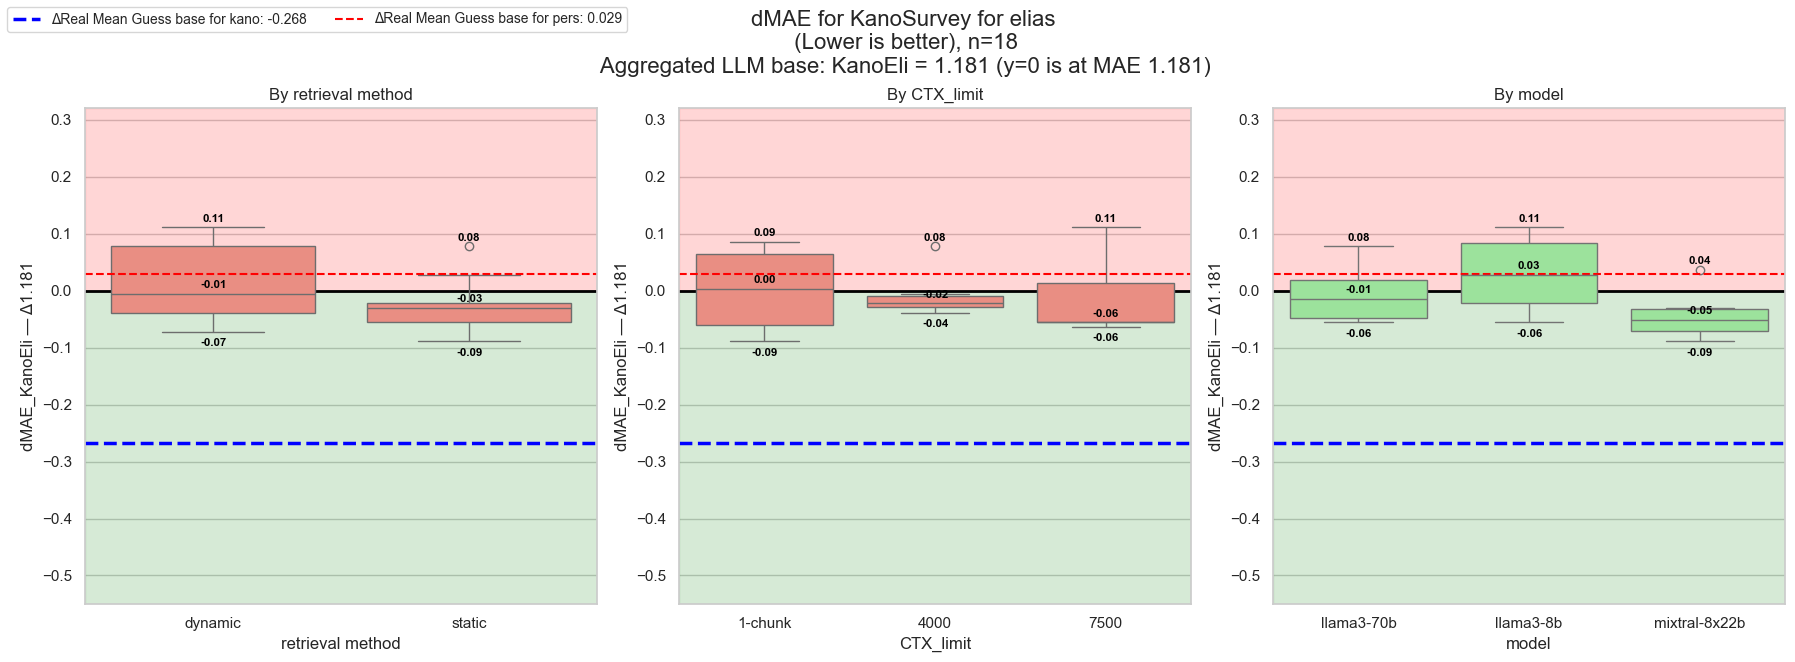

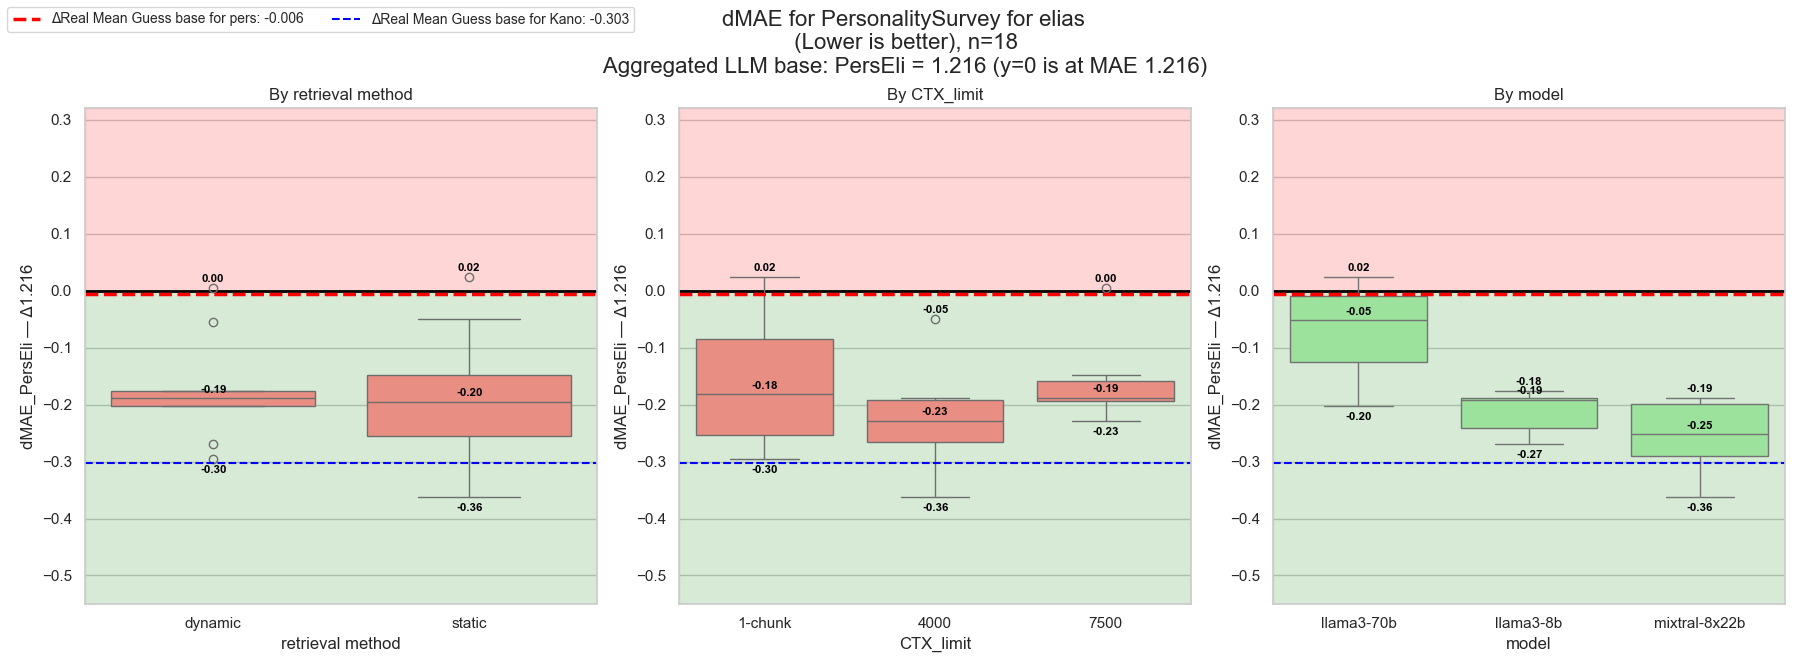

In [194]:
for subj in ['airidas', 'elias']:
    for srv in ['KanoSurvey', "PersonalitySurvey"]:
        base_name = srv[:4]
        if subj == 'airidas': base_name += 'Airi'
        else: base_name += 'Eli'
        base_val = global_base_scores["by_survey_subject"][base_name]
        for index, sim_row in dfg.iterrows():
            for key, value_name in compare_to_custom_base(sim_row, base_val=base_val, base_name=base_name).items():
                dfg.at[index, key] = value_name

        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv) & (dfg['SUBJECT'] == subj)]
        parameters = ['retrieval method', 'CTX_limit', 'model']
        plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts
        lines, labels = [], [] # To keep track of legend handles
        for i, param in enumerate(parameters):
            ax = plt.subplot(1, 3, i + 1)  # Horizontal layout of plots
            ax.grid(True)
            ax.axhline(0, color='black', linewidth=2) 
            ax.axhspan(-0.55, 0, color='green', alpha=0.16)  # Stylish green background below zero
            ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
            color = getGlobalColorByParam(param)
            #### Extract median values and their positions ######
            grouped_data = filtered_df.groupby(param)[f'dMAE_{base_name}']
            mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
            pos = range(len(mins))  # Positions of the boxplots
            vertical_offset = 0.01  # offset each text to avoid clutter
            for tick in pos:
                ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            #####################################################
            sns.boxplot(x=param, y=f'dMAE_{base_name}', color=color, data=filtered_df)
            plt.title(f'By {param}')
            plt.ylabel(f'dMAE_{base_name} — Δ{round(base_val,3)}')
            plt.xticks(rotation=0) 
            plt.ylim(bottom=-0.55, top=0.32)  # Adjust y-limits
            
            if srv == 'KanoSurvey':
                lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--', linewidth=2.5), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                labels_new = [f'ΔReal Mean Guess base for kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

            elif srv == 'PersonalitySurvey':
                lines_new = [plt.axhline(y=1.210 - base_val, color='red', linestyle='--', linewidth=2.5), plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--')]
                labels_new = [f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}',f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}']
            else:
                lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

            if i == 1:  # Only need these once for creating the legend
                lines.extend(lines_new)
                labels.extend(labels_new)
        
        plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
        plt.tight_layout()
        plt.suptitle(f'dMAE for {srv} for {subj}\n (Lower is better), n={len(filtered_df)}\n Aggregated LLM base: {base_name} = {round(base_val,3)} (y=0 is at MAE {round(base_val,3)})', y=1.10, fontsize=16) 
        plt.show()

#### Two Gansters

In [ ]:
for llm in ['llama3-8b', 'llama3-70b', 'mixtral-8x22b']:
    for subj in ['airidas', 'elias']:
        for srv in ['KanoSurvey', "PersonalitySurvey"]:
            filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv) & (dfg['SUBJECT'] == subj) & (dfg['model'] == llm)]
            base_sign = filtered_df.iloc[0]["base_sim_signature"]
            base_name = utils.unclutterSignature(base_sign)
            if subj == 'airidas': base_val = dfg[(dfg['sim_signature'] == base_sign)]['MAE_airi'].mean()
            else: base_val = dfg[(dfg['sim_signature'] == base_sign)]['MAE_eli'].mean()
            parameters = ['retrieval method', 'CTX_limit']
            plt.figure(figsize=(10, 6))  # Adjust the figure size for horizontal layouts
            lines, labels = [], [] # To keep track of legend handles
            for i, param in enumerate(parameters):
                ax = plt.subplot(1, 2, i + 1)  # Horizontal layout of plots
                ax.grid(True)
                ax.axhline(0, color='black', linewidth=2) 
                ax.axhspan(-0.95, 0, color='green', alpha=0.16)  # Stylish green background below zero
                ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
                color = getGlobalColorByParam(param)
                #### Extract median values and their positions ######
                grouped_data = filtered_df.groupby(param)[f'dMAE']
                mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
                pos = range(len(mins))  # Positions of the boxplots
                vertical_offset = 0.01  # offset each text to avoid clutter
                for tick in pos:
                    ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                    ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                    ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                #####################################################
                sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
                plt.title(f'By {param}')
                plt.ylabel(f'dMAE_atomic — Δ{round(base_val,3)}')
                plt.xticks(rotation=0) 
                if base_val > 1.6: plt.ylim(bottom=-0.95, top=0.1) 
                else: plt.ylim(bottom=-0.55, top=0.32)  # Adjust y-limits
                
                if srv == 'KanoSurvey':
                    lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--', linewidth=2.5), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                    labels_new = [f'ΔReal Mean Guess base for kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']
                elif srv == 'PersonalitySurvey':
                    lines_new = [plt.axhline(y=1.210 - base_val, color='red', linestyle='--', linewidth=2.5), plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--')]
                    labels_new = [f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}',f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}']
                else:
                    lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                    labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

                if i == 1:  # Only need these once for creating the legend
                    lines.extend(lines_new)
                    labels.extend(labels_new)
            
            plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
            plt.tight_layout()
            plt.suptitle(f'\n\ndMAE for {srv} for {subj} for {llm}\n (Lower is better), n={len(filtered_df)}\n Atomic LLM base: {base_name} = {round(base_val,3)} (y=0 is at MAE {round(base_val,3)})', y=1.16, fontsize=13) 
            plt.show()

In [196]:
ddf = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == "KanoSurvey") & (dfg['SUBJECT'] == "airidas") & (dfg['model'] == "llama3-8b")]

In [197]:
base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')]['MAE_eli'].mean()

1.0666666666666667

In [198]:
importlib.reload(utils)

<module 'shared_utils' from 'g:\\My Drive\\CBS\\Thesis\\Thesis\\shared_utils.py'>

### Ultimate Universal (UU) graph
Combines MAE&dMAE

(We invented the name for it ourselves)

#### Setup

In [393]:
def various_or_single(x):
    """
    Determines, whether a clumnn has uniform (all the same) values or they vary. 
    Returns:
        str: Either the uniform single value, or literal '(various)'
    """
    if x.nunique() == 1:
        return x.iloc[0]
    else:
        return '(various)'
    
def format_ctx_limit(row: pd.Series) -> str:
    """
    Formats the CTX_limit column for better readability.

    Args:
        row (pd.Series): A row of the dataframe
    
    Returns:
        str: A formatted string
    """
    formatted = "max "
    if row["CTX_limit"] == "1-chunk":
        formatted += f"{row["prompt_tokens_max"]}"
    else:
        formatted += row["CTX_limit"]

    return formatted + " tk."

def format_subject(subject: str) -> str:
    if subject == 'airidas':
        return 'Airidas'
    if subject == 'elias':
        return 'Elias'
    else:
        return subject

#### UU Aggregated

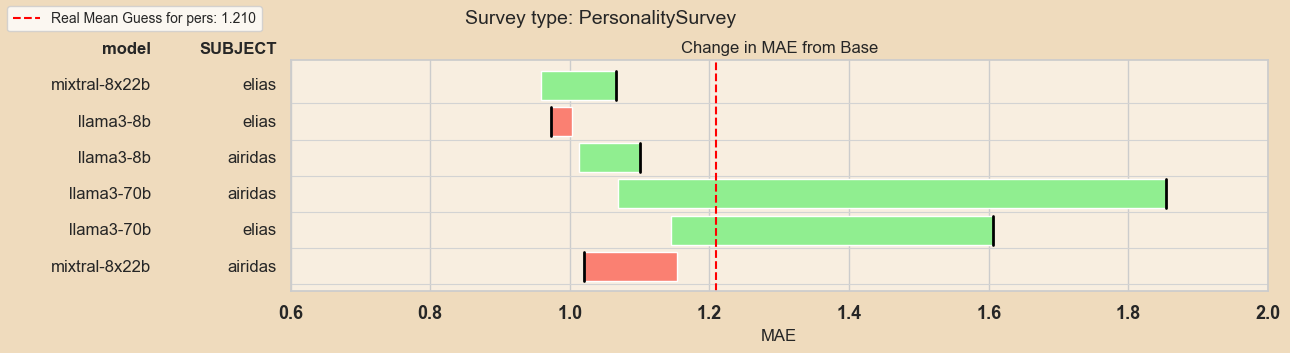

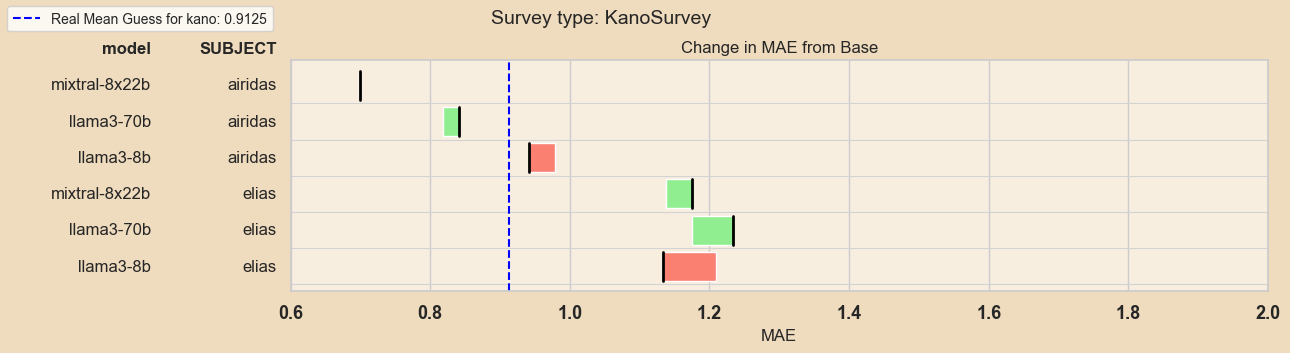

In [200]:


# Determine aggregation methods based on column data types
aggregations = {}
for column, dtype in dfg.dtypes.items():
    if dtype in ['int64', 'float64']:  # Add other numeric types if needed
        aggregations[column] = 'mean'
    else:
        aggregations[column] = various_or_single

# Apply group by with the dynamic aggregation dictionary
group_cols = ['SUBJECT', 'model', "survey_type"]
df_grouped = dfg.groupby(group_cols).agg(aggregations).drop(columns=group_cols).reset_index()
graphs = [
    {
        "srv": "PersonalitySurvey",
    },
    {
        "srv": "KanoSurvey",
    },
]

for graph in graphs:
    # Calculate start and end points
    ddf = df_grouped[(df_grouped['is_base'] == False) & (df_grouped['survey_type'] == graph["srv"])].sort_values(ascending=False, by='MAE').reset_index()
    ddf = ddf.drop(columns=["index"])

    ddf['start'] = ddf['MAE_base']
    ddf['end'] = ddf['MAE_base'] + ddf['dMAE']

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(23, 3))
    fig.patch.set_facecolor('#efdbbd')
    # Plot each bar
    for i, row in ddf.iterrows():
    
        color = 'lightgreen' if row['dMAE'] <= 0 else 'salmon'
        group_signature = " ".join([str(row[col]) for col in group_cols])
        ax.barh(group_signature, row['end'] - row['start'], left=row['start'], color=color)
        ax.plot([row['MAE_base'], row['MAE_base']], [i-0.4, i+0.4], color='black', linewidth=2)
        

    ax.set_yticks([]) # Remove Y-axis tick labels since we will replace them with detailed text
    ax.set_xlim(0.60, 1.82)
    table_text_props = {'verticalalignment': 'center', 'horizontalalignment': 'right'}

    gap = -0.18
    start = 0.58
    x_positions = []
    for i in range(4):
        x_positions.append(start + gap * i)

    for i in range(len(ddf)):
        ax.text(x=x_positions[0], y=i, s=ddf.loc[i, 'SUBJECT'], **table_text_props)
        ax.text(x=x_positions[1], y=i, s=ddf.loc[i, 'model'], **table_text_props)
        # The below is commented. Uncomment if you want to indicate that the two vars are (variable). Also uncomment two other lines (search COMMENT#4000)
        # ax.text(x=x_positions[2], y=i, s=ddf.loc[i, 'retrieval method'], **table_text_props)
        # ax.text(x=x_positions[3], y=i, s=ddf.loc[i, 'CTX_limit'], **table_text_props)
        ax.axhline(y=i - 0.5, xmin=0, xmax=1, color='lightgray', linewidth=0.8)
        

    # Add table column headers
    ax.text(x=x_positions[0], y=len(ddf), s="SUBJECT", fontweight='bold', **table_text_props)
    ax.text(x=x_positions[1], y=len(ddf), s="model", fontweight='bold', **table_text_props)
     # The below is commented. Uncomment if you want to indicate that the two vars are (variable). Also uncomment two other lines (search COMMENT#4000)
    # ax.text(x=x_positions[2], y=len(ddf), s='retrieval', fontweight='bold', **table_text_props)
    # ax.text(x=x_positions[3], y=len(ddf), s='CTX_limit', fontweight='bold', **table_text_props)
    
    # Adjust the plot layout to make room for the table but with smaller gaps
    plt.subplots_adjust(right=0.55)

    lines = []
    labels = []
        # Adding horizontal lines for guidelines
    if graph["srv"] == 'KanoSurvey':
        lines_new = [plt.axvline(x=0.9125, color='blue', linestyle='--')]
        labels_new = ['Real Mean Guess for kano: 0.9125']
    elif graph["srv"] == 'PersonalitySurvey':
        lines_new = [plt.axvline(x=1.210, color='red', linestyle='--')]
        labels_new = ['Real Mean Guess for pers: 1.210']
    else:
        lines_new = [plt.axvline(x=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')]
        labels_new = ['Real Mean Guess for Kano: 0.9125', 'Real Mean Guess for pers: 1.210']
    
    lines.extend(lines_new)
    labels.extend(labels_new)
    plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)


    # Adding labels and title
    ax.set_xlabel('MAE')
    ax.set_title('Change in MAE from Base')
    super_format_ax(ax)
    ax.set_facecolor('#f8eee0')

    fig.suptitle(f"Survey type: {graph['srv']}", fontsize=14, x=0.26, y=1.05)

    # Show plot
    plt.show()



#### UU Granular

[0.58, 0.39999999999999997, 0.21999999999999997, 0.039999999999999925]


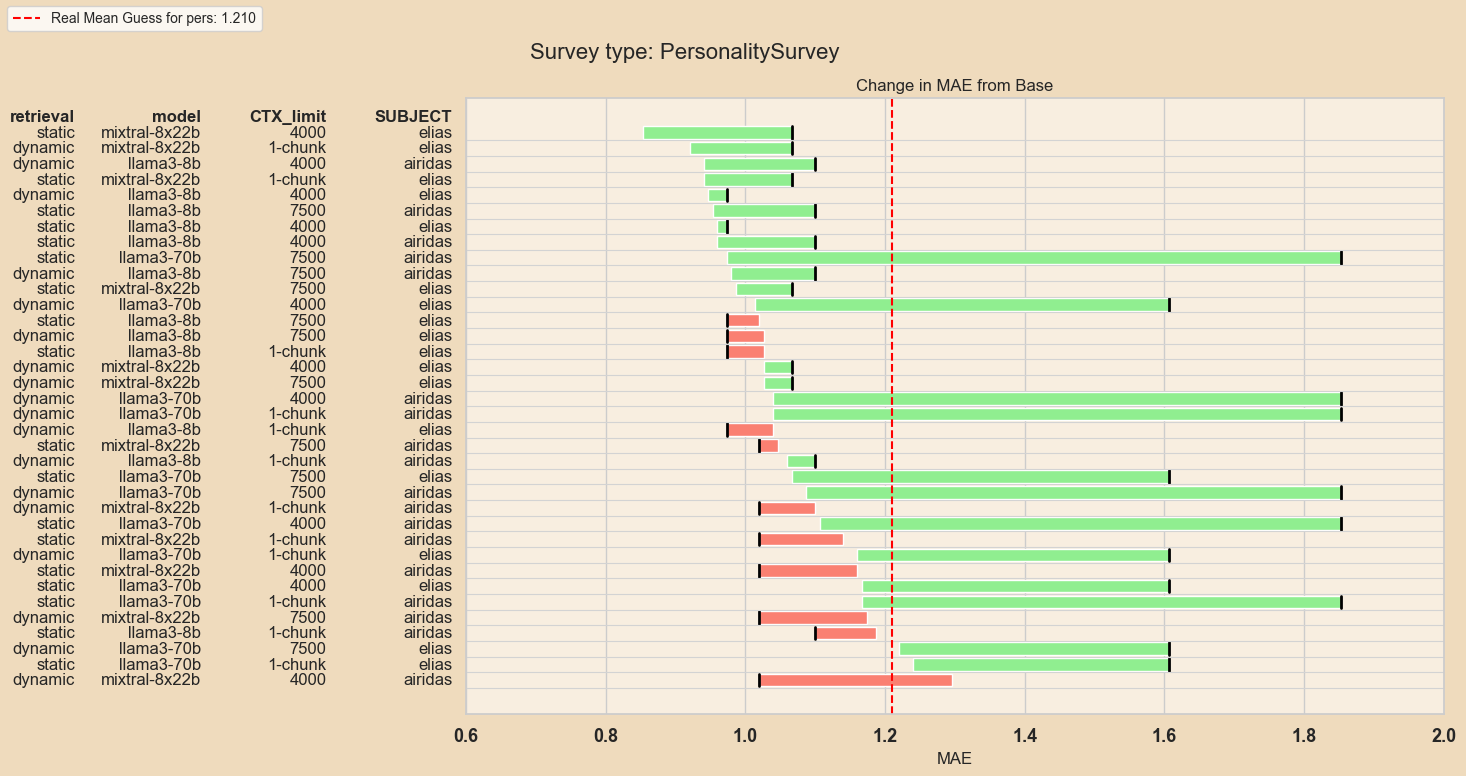

[0.58, 0.39999999999999997, 0.21999999999999997, 0.039999999999999925]


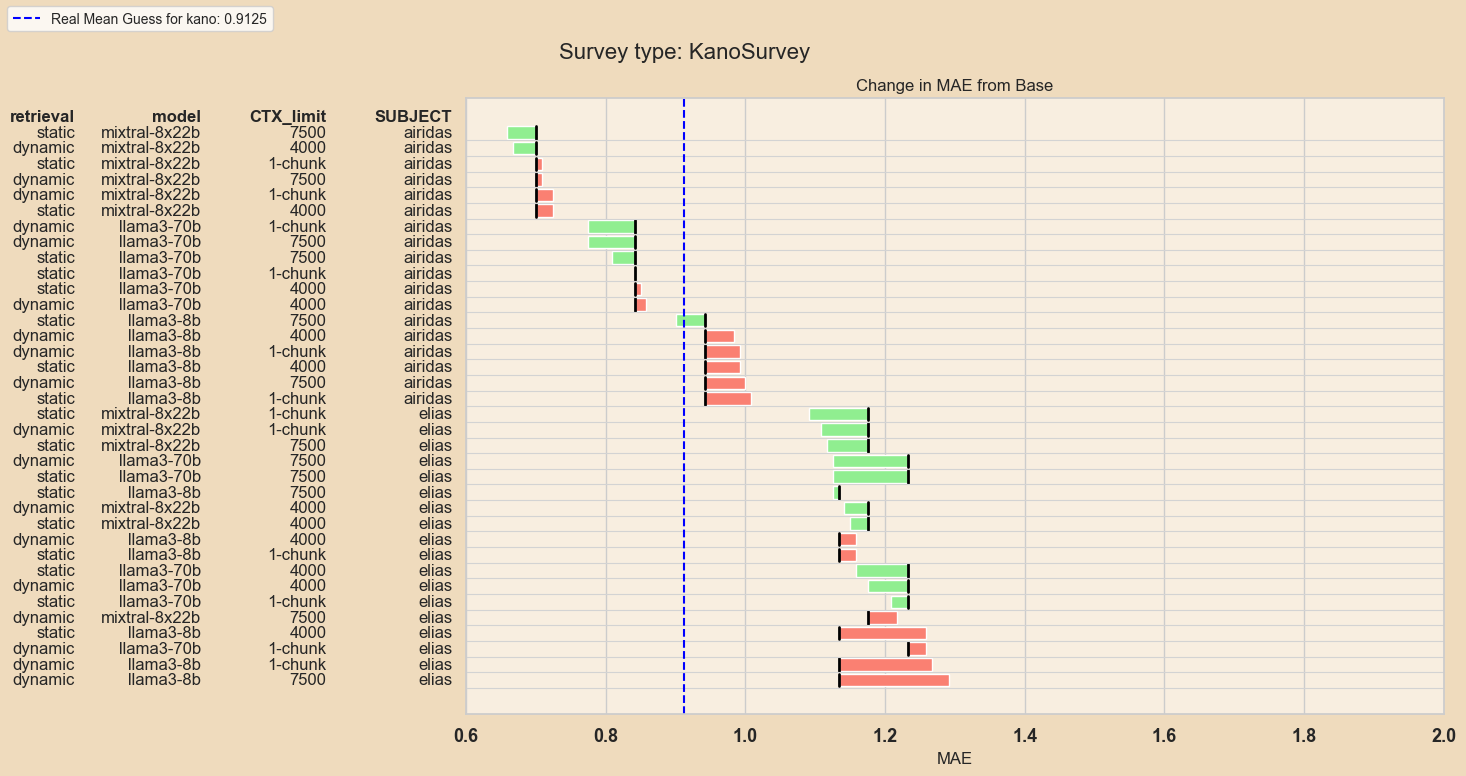

In [201]:
graphs = [
    {
        "srv": "PersonalitySurvey",
    },
    {
        "srv": "KanoSurvey",
    },
]

for graph in graphs:
    # Calculate start and end points
    ddf = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == graph["srv"])].sort_values(ascending=False, by='MAE').reset_index()

    ddf['start'] = ddf['MAE_base']
    ddf['end'] = ddf['MAE_base'] + ddf['dMAE']

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(23, 8))
    fig.patch.set_facecolor('#efdbbd')

    # Plot each bar
    for i, row in ddf.iterrows():
        color = 'lightgreen' if row['dMAE'] <= 0 else 'salmon' 
        ax.barh(row['sim_signature'], row['end'] - row['start'], left=row['start'], color=color)
        ax.plot([row['MAE_base'], row['MAE_base']], [i-0.4, i+0.4], color='black', linewidth=2)

    ax.set_yticks([]) # Remove Y-axis tick labels since we will replace them with detailed text
    ax.set_xlim(0.60, 1.82)
    table_text_props = {'verticalalignment': 'center', 'horizontalalignment': 'right'}

    gap = -0.18
    start = 0.58
    x_positions = []
    for i in range(4):
        x_positions.append(start + gap * i)
    print(x_positions)

    for i in range(len(ddf)):
        ax.text(x=x_positions[0], y=i, s=ddf.loc[i, 'SUBJECT'], **table_text_props)
        ax.text(x=x_positions[1], y=i, s=ddf.loc[i, 'CTX_limit'], **table_text_props)
        ax.text(x=x_positions[2], y=i, s=ddf.loc[i, 'model'], **table_text_props)
        ax.text(x=x_positions[3], y=i, s=ddf.loc[i, 'retrieval method'], **table_text_props)
        # Draw horizontal lines between rows
        ax.axhline(y=i - 0.5, xmin=0, xmax=1, color='lightgray', linewidth=0.8)

    # Add table column headers
    ax.text(x=x_positions[0], y=len(ddf), s="SUBJECT", fontweight='bold', **table_text_props)
    ax.text(x=x_positions[1], y=len(ddf), s="CTX_limit", fontweight='bold', **table_text_props)
    ax.text(x=x_positions[2], y=len(ddf), s="model", fontweight='bold', **table_text_props)
    ax.text(x=x_positions[3], y=len(ddf), s="retrieval", fontweight='bold', **table_text_props)
    # Adjust the plot layout to make room for the table but with smaller gaps
    plt.subplots_adjust(right=0.55)

    lines = []
    labels = []
        # Adding horizontal lines for guidelines
    if graph["srv"] == 'KanoSurvey':
        lines_new = [plt.axvline(x=0.9125, color='blue', linestyle='--')]
        labels_new = ['Real Mean Guess for kano: 0.9125']
    elif graph["srv"] == 'PersonalitySurvey':
        lines_new = [plt.axvline(x=1.210, color='red', linestyle='--')]
        labels_new = ['Real Mean Guess for pers: 1.210']
    else:
        lines_new = [plt.axvline(x=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')]
        labels_new = ['Real Mean Guess for Kano: 0.9125', 'Real Mean Guess for pers: 1.210']
    
    lines.extend(lines_new)
    labels.extend(labels_new)
    plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)

    # Adding labels and title
    ax.set_xlabel('MAE')
    ax.set_title('Change in MAE from Base')
    super_format_ax(ax)
    ax.set_facecolor('#f8eee0')

    fig.suptitle(f"Survey type: {graph['srv']}", fontsize=16, x=0.22, y=0.95)

    # Show plot
    plt.show()

#### UU v2 Group Best

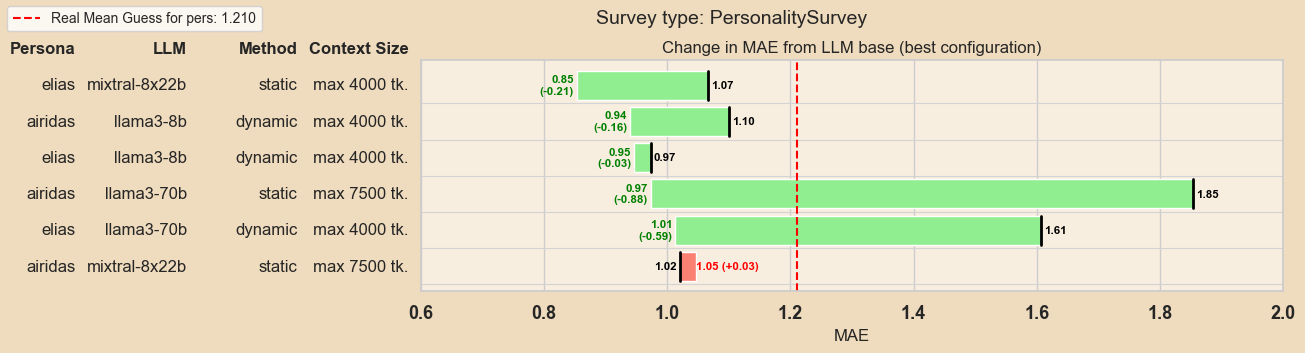

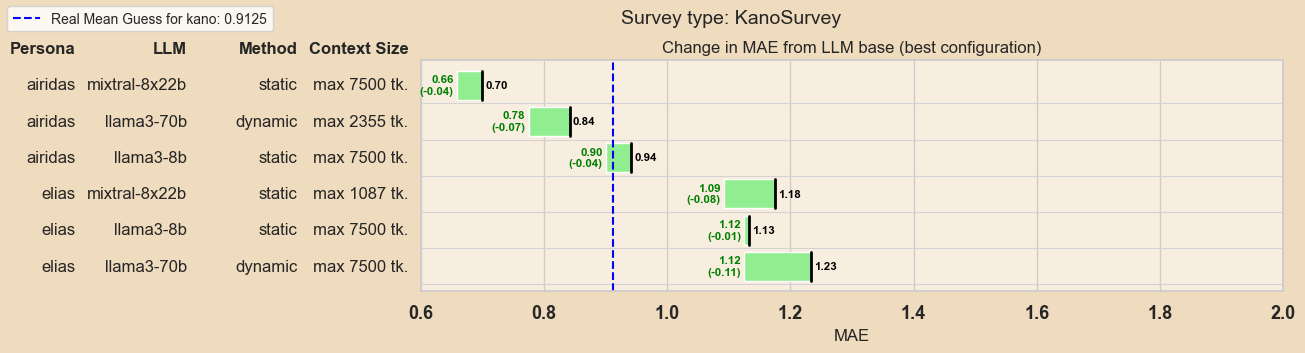

In [279]:
# Apply group by with the dynamic aggregation dictionary
group_cols = ['SUBJECT', 'model', "survey_type"]
dfg_nobase = dfg[dfg['is_base'] == False]

# Get the rows with best performance (min MAE) for each group
ddbf = dfg_nobase.loc[dfg_nobase.groupby(['SUBJECT', 'model', 'survey_type'])['MAE'].idxmin()]
graphs = [
    {
        "srv": "PersonalitySurvey",
    },
    {
        "srv": "KanoSurvey",
    },
]

for graph in graphs:
    # Calculate start and end points
    ddf = ddbf[(ddbf['survey_type'] == graph["srv"])].sort_values(ascending=False, by='MAE').reset_index()
    ddf = ddf.drop(columns=["index"])

    ddf['start'] = ddf['MAE_base']
    ddf['end'] = ddf['MAE_base'] + ddf['dMAE']

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(23, 3))
    fig.patch.set_facecolor('#efdbbd')
    # Plot each bar
    for i, row in ddf.iterrows():
    
        color = 'lightgreen' if row['dMAE'] <= 0 else 'salmon'
        group_signature = " ".join([str(row[col]) for col in group_cols])
        ax.barh(group_signature, row['end'] - row['start'], left=row['start'], color=color)
        ax.plot([row['MAE_base'], row['MAE_base']], [i-0.4, i+0.4], color='black', linewidth=2)

        # Ticks
        
        if row['dMAE'] <= 0:
            ax.text(row['end']-0.005, i+0.16, f'{row["end"]:.2f}', va='center', ha='right', color='green', size='x-small', weight='semibold')
            ax.text(row['end']-0.005, i-0.16, f'({row['dMAE']:.2f})', va='center', ha='right', color='green', size='x-small', weight='semibold')
            ax.text(row['MAE_base']+0.005, i, f'{row["MAE_base"]:.2f}', va='center', ha='left', color='black',  size='x-small', weight='semibold')
        else: 
            ax.text(row['end'], i, f'{row["end"]:.2f} (+{row['dMAE']:.2f})', va='center', ha='left', color='red', size='x-small', weight='semibold')
            ax.text(row['MAE_base']-0.005, i, f'{row["MAE_base"]:.2f}', va='center', ha='right', color='black',  size='x-small', weight='semibold')
        

    ax.set_yticks([]) # Remove Y-axis tick labels since we will replace them with detailed text
    ax.set_xlim(0.60, 1.82)
    table_text_props = {'verticalalignment': 'center', 'horizontalalignment': 'right'}

    gap = -0.18
    start = 0.58
    x_positions = []
    for i in range(4):
        x_positions.append(start + gap * i)

    for i in range(len(ddf)):
        ax.text(x=x_positions[3], y=i, s=ddf.loc[i, 'SUBJECT'], **table_text_props)
        ax.text(x=x_positions[2], y=i, s=ddf.loc[i, 'model'], **table_text_props)

        ax.text(x=x_positions[1], y=i, s=ddf.loc[i, 'retrieval method'], **table_text_props)
        ax.text(x=x_positions[0], y=i, s=format_ctx_limit(ddf.loc[i]), **table_text_props)

        # ax.text(x=x_positions[0], y=i, s="n=3", **table_text_props)
        ax.axhline(y=i - 0.5, xmin=0, xmax=1, color='lightgray', linewidth=0.8)
        

    # Add table column headers
    ax.text(x=x_positions[3], y=len(ddf), s="Persona", fontweight='bold', **table_text_props)
    ax.text(x=x_positions[2], y=len(ddf), s="LLM", fontweight='bold', **table_text_props)

    ax.text(x=x_positions[1], y=len(ddf), s='Method', fontweight='bold', **table_text_props)
    ax.text(x=x_positions[0], y=len(ddf), s='Context Size', fontweight='bold', **table_text_props)

    # ax.text(x=x_positions[0], y=len(ddf), s='n', fontweight='bold', **table_text_props)

    
    
    # Adjust the plot layout to make room for the table but with smaller gaps
    plt.subplots_adjust(right=0.50)

    lines = []
    labels = []
        # Adding horizontal lines for guidelines
    if graph["srv"] == 'KanoSurvey':
        lines_new = [plt.axvline(x=0.9125, color='blue', linestyle='--')]
        labels_new = ['Real Mean Guess for kano: 0.9125']
    elif graph["srv"] == 'PersonalitySurvey':
        lines_new = [plt.axvline(x=1.210, color='red', linestyle='--')]
        labels_new = ['Real Mean Guess for pers: 1.210']
    else:
        lines_new = [plt.axvline(x=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')]
        labels_new = ['Real Mean Guess for Kano: 0.9125', 'Real Mean Guess for pers: 1.210']
    
    lines.extend(lines_new)
    labels.extend(labels_new)
    plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)


    # Adding labels and title
    ax.set_xlabel('MAE')
    ax.set_title('Change in MAE from LLM base (best configuration)')
    super_format_ax(ax)
    ax.set_facecolor('#f8eee0')

    fig.suptitle(f"Survey type: {graph['srv']}", fontsize=14, x=0.26, y=1.05)

    # Show plot
    plt.show()



#### UU ELI5 Graph

In [463]:
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
def pp(x, decimals=0):
    """
    Formats a percentage value to be displayed as a string.
    """
    return f'{x*100:.{decimals}f}%'

formatter = FuncFormatter(lambda x, _: pp(x, decimals=0))

### Remapping
def remap_to_simple(x, p0, p1=0):
    return (x - p0) / (p1 - p0)

# def format_survey_type(survey_type: str) -> str:
#     if survey_type == 'KanoSurvey':
#         return 'Kano'
#     elif survey_type == 'PersonalitySurvey':
#         return 'Personality'
#     else:
#         return survey_type

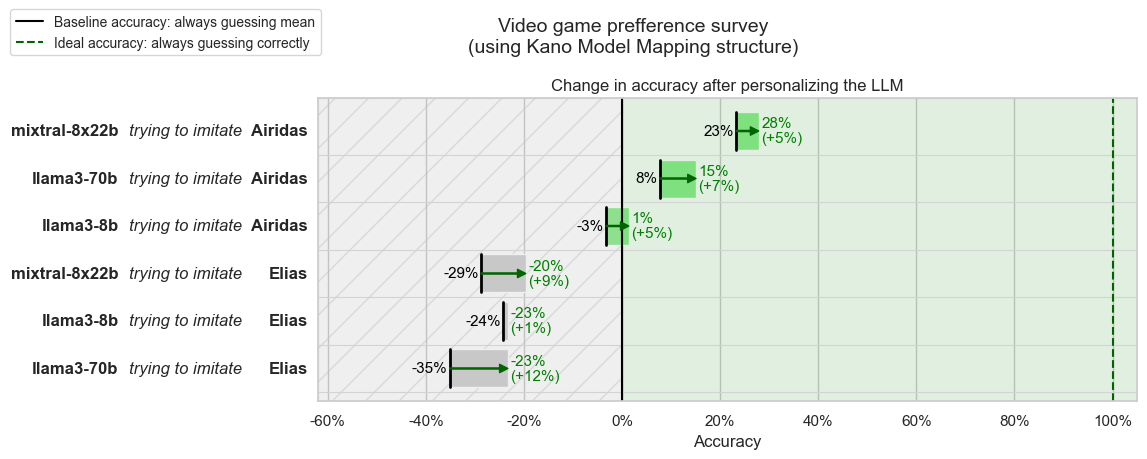

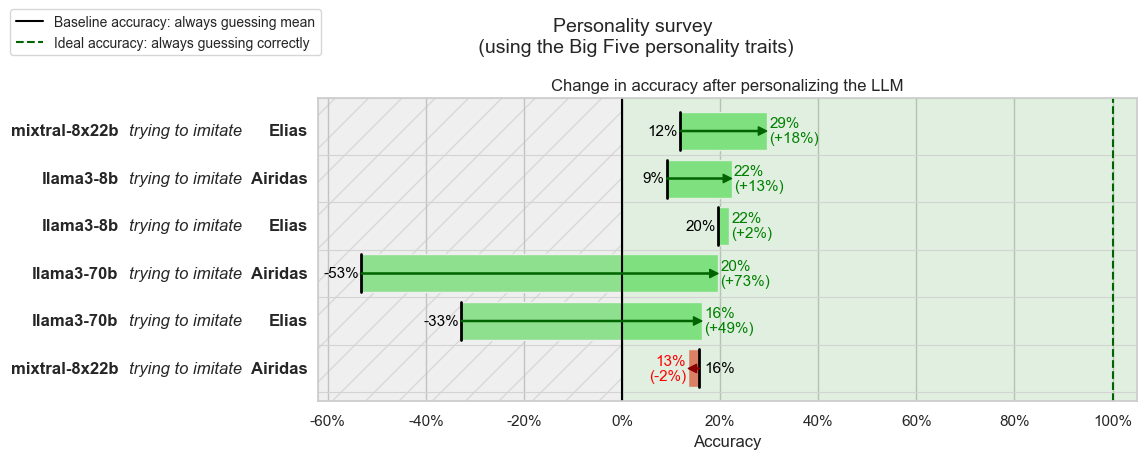

In [556]:
# Global settings
ARROW_STYLE = {"width":0.8, "headwidth":6, "headlength":6}
VALUE_LABEL_STYLE = {'va': 'center', "fontsize":11}
PLOT_LABELS = {"kano": 'Video game prefference survey\n(using Kano Model Mapping structure)', "pers":'Personality survey\n (using the Big Five personality traits)'}
LEGEND_LABELS = {"kano": 'Baseline accuracy: always guessing mean', "pers":'Baseline accuracy: always guessing mean'}
LEGEND_LABEL_MAX = "Ideal accuracy: always guessing correctly"

# Get the rows with best performance (min MAE) for each group
group_cols = ['SUBJECT', 'model', "survey_type"]
dfg_nobase = dfg[dfg['is_base'] == False]
ddbf = dfg_nobase.loc[dfg_nobase.groupby(['SUBJECT', 'model', 'survey_type'])['MAE'].idxmin()]

# Graphic individualization
graphs = [
    {
        "srv": "KanoSurvey",
    },
    {
        "srv": "PersonalitySurvey",
    },
]

for graph in graphs:
    ddf = ddbf[ddbf['survey_type'] == graph["srv"]].sort_values(ascending=False, by='MAE').reset_index()
    ddf = ddf.drop(columns=["index"])

    ### Remapping
    # Remaps where 1 is interpreted as the maximum accuracy, where MAE is 0, while 0 is the Naive Guess Accuracy
    # Linearly scales between these two points.
    p0 = global_base_scores["mean_guess"]["kano" if graph["srv"] == 'KanoSurvey' else "pers"]

    values_to_remap = ['MAE', 'MAE_base']
    for value_name in values_to_remap:
        ddf[value_name] = ddf[value_name].apply(lambda x: remap_to_simple(x, p0=p0))

    ddf["dMAE"] = ddf["MAE"] - ddf["MAE_base"] # Perhaps remove. It's not needed for the simple remap
    ###

    # Calculate start and end points

    ddf['start'] = ddf['MAE_base']
    ddf['end'] = ddf['MAE']

    ADD_TO_MOST_IMPORTANT_COLUMNS = ["MAE_rm","dMAE_rm", "start", "end"]

    # Define Sizing



    # Create figure and axis
    fig, ax = plt.subplots(figsize=(18, 3))
    # fig.patch.set_facecolor('#efdbbd')
    # Plot each bar
    for i, row in ddf.iterrows():
    
        if row['dMAE'] <= 0:
            color = 'salmon'
        elif  row["MAE"] > 0:
            color = 'lightgreen'
        else:
            color = 'lightgray'
        # color = 'salmon' if row['dMAE'] <= 0 else 'lightgreen'
        group_signature = " ".join([str(row[col]) for col in group_cols])
        ax.barh(group_signature, row['end'] - row['start'], left=row['start'], color=color)
        ax.plot([row['MAE_base'], row['MAE_base']], [i-0.4, i+0.4], color='black', linewidth=2)

        # Ticks
        
        if row['MAE'] < row['MAE_base']:
            ax.text(row['end']-0.005, i+0.16, f'{pp(row["end"])}', ha='right', color='red', **VALUE_LABEL_STYLE)
            ax.text(row['end']-0.005, i-0.16, f'({pp(row['dMAE'])})', ha='right', color='red', **VALUE_LABEL_STYLE)
            ax.text(row['MAE_base']+0.01, i, f'{pp(row["MAE_base"])}', ha='left', color='black', **VALUE_LABEL_STYLE)

            if abs(row['dMAE']) > 0.01:
                ax.annotate("", xy=(row['MAE'], i), xytext=(row['MAE_base'], i),
                    arrowprops=dict(**ARROW_STYLE,  color='darkred'))
        else: 
            ax.text(row['end']+0.005, i+0.16, f'{pp(row["end"])}', ha='left', color='green', **VALUE_LABEL_STYLE)
            ax.text(row['end']+0.005, i-0.16, f'(+{pp(row['dMAE'])})', ha='left', color='green', **VALUE_LABEL_STYLE)
            ax.text(row['MAE_base']-0.005, i, f'{pp(row["MAE_base"])}', ha='right', color='black', **VALUE_LABEL_STYLE)
            if abs(row['dMAE']) > 0.025:
                ax.annotate("", xy=(row['MAE'], i), xytext=(row['MAE_base'], i),
                    arrowprops=dict(**ARROW_STYLE,  color='darkgreen'))
        

    ax.set_yticks([]) # Remove Y-axis tick labels since we will replace them with detailed text
    ax.set_xlim(-0.62, 1.05)
    
    table_text_props = {'verticalalignment': 'center', 'horizontalalignment': 'right'}
    start = ax.get_xlim()[0] - 0.02

    column_scalings = [0.75,1.4,1,1,1]

    def get_offset(i, gap=-0.18):
        cs = column_scalings[:i]
        offset = start
        for i2, scaling in enumerate(cs):
            offset  += gap * scaling
        return offset

    # Define the table functions
    table_values = [
        lambda idx, i: ax.text(x=get_offset(idx), y=i, s=ddf.loc[i, 'model'], weight= 'semibold', **table_text_props),
        lambda idx, i: ax.text(x=get_offset(idx), y=i, s="trying to imitate", fontstyle='italic', **table_text_props),
        lambda idx, i: ax.text(x=get_offset(idx), y=i, s=format_subject(ddf.loc[i, 'SUBJECT']), weight= 'semibold', **table_text_props),
        # lambda idx, i: ax.text(x=get_offset(idx), y=i, s=ddf.loc[i, 'retrieval method'], **table_text_props),
        # lambda idx, i: ax.text(x=get_offset(idx), y=i, s=format_ctx_limit(ddf.loc[i]), **table_text_props),
    ]
    table_headers = [
        lambda idx: ax.text(x=get_offset(idx), y=len(ddf), s="", fontweight='bold', **table_text_props),
        lambda idx: ax.text(x=get_offset(idx), y=len(ddf), s="", fontweight='bold', **table_text_props),
        lambda idx: ax.text(x=get_offset(idx), y=len(ddf), s="", fontweight='bold', **table_text_props),
        # lambda idx: ax.text(x=get_offset(idx), y=len(ddf), s='Method', fontweight='bold', **table_text_props),
        # lambda idx: ax.text(x=get_offset(idx), y=len(ddf), s='Context Size', fontweight='bold', **table_text_props),
    ]

    # Add values and headers
    for i in range(len(ddf)):
        for i2, func in enumerate(reversed(table_values)):
            func(i2, i)
        ax.axhline(y=i - 0.5, xmin=0, xmax=1, color='lightgray', linewidth=0.8)
        
    for i, func in enumerate(reversed(table_headers)):
        func(i)

    
    # Adjust the plot layout to make room for the table but with smaller gaps
    plt.subplots_adjust(right=0.58, bottom=-0.13)

    lines = []
    labels = []
        # Adding horizontal lines for guidelines
    if graph["srv"] == 'KanoSurvey':
        lines_new = [plt.axvline(x=0, color='black', linestyle='-')]
        labels_new = [LEGEND_LABELS['kano']]
    elif graph["srv"] == 'PersonalitySurvey':
        lines_new = [plt.axvline(x=0, color='black', linestyle='-')]
        labels_new = [LEGEND_LABELS['pers']]
    else:
        lines_new = [plt.axvline(x=0, color='black', linestyle='-'), plt.axhline(y=0, color='darkred', linestyle='-')]
        labels_new = [LEGEND_LABELS['kano'], LEGEND_LABELS['pers']]

    lines_new.append(plt.axvline(x=1, color='darkgreen', linestyle='--'))
    labels_new.append(LEGEND_LABEL_MAX)
    
    lines.extend(lines_new)
    labels.extend(labels_new)
    plt.figlegend(lines, labels, loc='upper left', ncol=1, fontsize=10, bbox_to_anchor=(-0.05, 1.2))

    ax.axvspan(ax.get_xlim()[0], 0, color='gray', alpha=0.12)
    ax.axvspan(0, ax.get_xlim()[1], color='green', alpha=0.12)



    # Adding labels and title
    ax.set_xlabel('Accuracy')
    ax.set_title('Change in accuracy after personalizing the LLM')
    # ax.set_facecolor('#f8eee0')
    
    fig.suptitle(PLOT_LABELS['kano' if graph['srv'] == "KanoSurvey" else 'pers' ] , fontsize=14, x=0.3, y=1.15)

    ax.xaxis.set_major_formatter(formatter)
    ax.add_patch(
    patches.Rectangle(
        xy=(0, -0.75),  # Bottom left corner of the rectangle
        width=-10,  # width of rectangle
        height=10,  # height of rectangle
        fill=True,  # fill the inside of the rectangle
        hatch='/',  # the stripe pattern
        fc='None',  # face color
        ec='gray', ##FF5959
        zorder=0,
        alpha=0.2,
    ))
    

    plt.show()


for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.remove(col)
MOST_IMPORTANT_COLUMNS = ADD_TO_MOST_IMPORTANT_COLUMNS + MOST_IMPORTANT_COLUMNS
ddf = utils.bring_to_front_important_columns(ddf, MOST_IMPORTANT_COLUMNS)



## ETC

#### Variable cleanup

In [ ]:
to_del = [
    "col",
    "a",
    "ax",
    "axs",
    "bars",
    "bar",
    'ddf',
    'df_filtered',
    'bar_value',
    'bars',
    'bars_len',
    'bars_start',
    'base_dfg',
    'base_name',
    'base_sign',
    'base_val',
    'dfQA',
    'dfQAs_kano',
    'dfQAs_kano_base',
    'dfQAs_pers',
    'dfQAs_pers_base',
    'df_filtered',
    'df_group',
    'df_group_70b',
    'df_group_8b',
    'df_group_8x22b',
    'df_grouped',
    'df_plot',
    'dff',
    'invalid_vals',
    'k',
    'key',
    'gs',
    'grouped_data',
    'models',
    'mode',
    'mins',
    'min_value',
    'metric_column',
    'average_value',
    'color',
    "colors",
    'column',
    'corr',
    'data',
    'data_rounded',
    "dfff",
    'dirs',
    'dtype',
    'fig',
    'file',
    'files',
    'gap',
    'graph',
    'graphs',
    'info',
    'labels',
    'labels_new',
    'line1',
    'line2',
]

for a in to_del:
    if a in locals():
        del locals()[a]

### Correlate: Airi vs Eli

In [ ]:
surv_kano = survey.KanoSurvey()
surv_pers = survey.PersonalitySurvey()

surv_kano.df = remap_answers_to_integers(surv_kano.df, surv_kano, remap_answer=False)
surv_pers.df = remap_answers_to_integers(surv_pers.df, surv_pers, remap_answer=False)

print(f"Kano {utils.calc_MAE(surv_kano.df["airidas"], surv_kano.df["elias"])}")
print(f"Pers {utils.calc_MAE(surv_pers.df["airidas"], surv_pers.df["elias"])}")
# now calc pearson correlation
import numpy as np
from scipy.stats import pearsonr
# get correlation
corr, _ = pearsonr(surv_kano.df["airidas"], surv_kano.df["elias"])
print(f'Pearsons correlation Kano: {corr}')
corr, _ = pearsonr(surv_pers.df["airidas"], surv_pers.df["elias"])
print(f'Pearsons correlation Pers: {corr}')

### (Unknown code)

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'mean_residual_Airidas_mean' and 'p-corr_Airidas_mean' are already computed as mean values in your aggregated dataframe
# Plotting for Airidas
plt.figure(figsize=(10, 6))
plt.scatter(dfg['p-corr_Airidas_mean'], dfg['MAE_airi_mean'], label='Airidas', alpha=0.5)

# Assuming 'mean_residual_Elias_mean' and 'p-corr_Elias_mean' are also computed as mean values
# Plotting for Elias
plt.scatter(dfg['p-corr_Elias_mean'], dfg['MAE_eli_mean'], color='red', label='Elias', alpha=0.5)

plt.title('Mean Residuals vs P-Corr')
plt.xlabel('P-Corr (mean)')
plt.ylabel('Mean Residuals (mean)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# Parameters for the normal distribution
mu = 2  # example mean
sigma = 1  # example standard deviation

# Define the integrand function
def integrand(x):
    return np.abs(x - 2) * norm.pdf(x, mu, sigma)

# Compute the integral
result, _ = quad(integrand, -np.inf, np.inf)
print("Mean Absolute Error:", result)

### *Some mathematical proof...*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
mu, n = 2, 100000
sigma = np.sqrt(0.9)
np.random.seed(0)
data = np.random.normal(mu, sigma, n)
data_rounded = np.round(data).clip(0, 4)
plt.figure(figsize=(4, 3))
plt.hist(data_rounded, bins=np.arange(6) - 0.5, edgecolor='black', color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(range(5))
stats_text = f"Mean: {np.mean(data_rounded)}\nMedian: {np.median(data_rounded)}\nMin: {np.min(data_rounded)}\nMax: {np.max(data_rounded)}\nUnique Values: {len(np.unique(data_rounded))}"
guess = 2
mae = np.mean(np.abs(data_rounded - guess))
stats_text += f"\nMean Absolute Error (MAE) when always guessing {guess}: {mae}"
plt.text(5, plt.ylim()[1] * 0.95, stats_text, fontsize=8, verticalalignment='top')
plt.show()